## Amazon Fine Food Review - SVM

### 1. Objective

                To find a review whether positive or negative

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import sqlite3
warnings.filterwarnings("ignore")

### 2. Data Cleaning 

In [2]:
#connecting database

con=sqlite3.connect("database.sqlite")

# Read data from database

raw_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

# Removal of Duplicates

pre_data=raw_data.drop_duplicates(['UserId','ProfileName','Time','Text'],keep="first")

# Removal of Unconditioning data (denominator>numerator)

pre_data=pre_data[pre_data.HelpfulnessNumerator<=pre_data.HelpfulnessDenominator]


# Finding NaN values in dataframe

# Reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html

# Findind NaN values

if pre_data.isnull().values.any() == False:
    print("There is No NaN values in the DataFrame")
else:
    print(" There is NaN values present in the DataFrame")

There is No NaN values in the DataFrame


In [3]:
# sort data based on Time 

filter_data=pre_data.sort_values(by=["Time"],axis=0)

# Class Label changing
# positive class label = 1
# negative class label = 0
a=[]
for i in filter_data["Score"]:
    if i > 3:
        a.append(1)
    else:
        a.append(0)
filter_data["Score"]=a

In [4]:
filter_data.shape

(364171, 10)

In [5]:
filter_data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### 3. Text Preprocessing

* We took the Text column for the further review idendification task, because text is the most important feature compared to other features. 

In [6]:
# References
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
# https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
# https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number/18082370#18082370
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://gist.github.com/sebleier/554280
# stemming tutorial: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# Lemmatisation tutorial: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
# NLTK Stemming package list: https://www.nltk.org/api/nltk.stem.html

from nltk.stem.snowball import EnglishStemmer
import re
from tqdm import tqdm
stemmer=EnglishStemmer()

In [8]:
raw_text_data=filter_data["Text"].values

In [9]:
# Stopwords

stopwords= set(['since','br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# expanding contractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
preprocessed_text_data=[]
for i in tqdm(raw_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alpha_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_text_data.append(b' '.join(k).decode())

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [08:58<00:00, 676.76it/s]


In [11]:
filter_data["Text"]=preprocessed_text_data

In [12]:
filter_data.shape

(364171, 10)

In [13]:
# we took the sample data size as 100k 

final_data=filter_data[:100000]
final_data.shape

(100000, 10)

### 4. Data Splitting

#### 4.1 Data splitting for Linear SVM

In [14]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [15]:
X=final_data.Text
Y=final_data.Score

In [16]:
x_1,x_test,y_1,y_test=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train,x_cv,y_train,y_cv=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train.shape,y_train.shape)

print("cv data size")
print(x_cv.shape,y_cv.shape)
print("Test data size")
print(x_test.shape,y_test.shape)

 Train data Size
(60000,) (60000,)
cv data size
(20000,) (20000,)
Test data size
(20000,) (20000,)


#### 4.2 Data splitting for RBF kernel

In [17]:
final_data_rbf=filter_data[:40000]

In [18]:
final_data_rbf.shape

(40000, 10)

In [21]:
X_1=final_data_rbf.Text
Y_1=final_data_rbf.Score

x_2,x_test_1,y_2,y_test_1=train_test_split(X_1,Y_1,test_size=0.2,random_state=40)
x_train_1,x_cv_1,y_train_1,y_cv_1=train_test_split(x_2,y_2,test_size=0.25,random_state=40)

In [22]:
print(" the shape of train data")
print(x_train_1.shape)
print("the shape of cv data")
print(x_cv_1.shape)
print("the shape of test data")
print(x_test_1.shape)

 the shape of train data
(24000,)
the shape of cv data
(8000,)
the shape of test data
(8000,)


### 5. Featurization

#### 5.1 Bag of Words (BOW)

##### 5.1.1 BOW for Linear SVM

In [50]:
# Reference
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

from sklearn.feature_extraction.text import CountVectorizer

In [51]:
bow_model=CountVectorizer(ngram_range=(1,2),min_df=5)

# BOW on Train data

bow_train_vec1=bow_model.fit_transform(x_train)

# BOW on cv data

bow_cv_vec1=bow_model.transform(x_cv)

# BOW on Test data

bow_test_vec1=bow_model.transform(x_test)

In [52]:
# the number of words in BOW or Vector size

print("The size of BOW vectorizer")
print(bow_train_vec1.get_shape()[1])

The size of BOW vectorizer
79401


##### 5.1.1 BOW for RBF Kernel

In [53]:
bow_model_1=CountVectorizer(ngram_range=(1,2),min_df=5,max_features=500)

# BOW on Train data

bow_train_vec2=bow_model_1.fit_transform(x_train_1)

# BOW on cv data

bow_cv_vec2=bow_model_1.transform(x_cv_1)

# BOW on Test data

bow_test_vec2=bow_model_1.transform(x_test_1)

In [54]:
# the number of words in BOW or Vector size

print("The size of BOW vectorizer")
print(bow_train_vec2.get_shape()[1])

The size of BOW vectorizer
500


#### 5.2 TFIDF

##### 5.2.1 TFIDF for Linear SVM

In [55]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=5)

# TFIDF on Train data 

tfidf_train_vec1=tfidf_model.fit_transform(x_train)

# TFIDF on cv data

tfidf_cv_vec1=tfidf_model.transform(x_cv)

# TFIDF on Test data

tfidf_test_vec1=tfidf_model.transform(x_test)

In [57]:
# the number of words in BOW or Vector size

print("The size of TFIDF vectorizer")
print(tfidf_train_vec1.get_shape()[1])

The size of TFIDF vectorizer
79401


##### 5.2.1 TFIDF for RBF Kernel

In [58]:
tfidf_model_1=TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=500)

# TFIDF on Train data 

tfidf_train_vec2=tfidf_model_1.fit_transform(x_train_1)

# TFIDF on cv data

tfidf_cv_vec2=tfidf_model_1.transform(x_cv_1)

# TFIDF on Test data

tfidf_test_vec2=tfidf_model_1.transform(x_test_1)

In [59]:
# the number of words in BOW or Vector size

print("The size of TFIDF vectorizer")
print(tfidf_train_vec2.get_shape()[1])

The size of TFIDF vectorizer
500


#### 5.3 W2V

##### 5.3.1 W2V for Linear SVM

In [33]:
# References
# https://radimrehurek.com/gensim/models/word2vec.html
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY

from gensim.models import Word2Vec

In [34]:
list_sentences_train=[]
for i in tqdm(list(x_train)):
    list_sentences_train.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 124097.46it/s]


In [35]:
word2vec_model=Word2Vec(list_sentences_train,min_count=5,size=50,workers=4)

In [36]:
word2vec_words_train=list(word2vec_model.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train[100:150])

 Number of words
_________________
 
10407
 sample words
_________________
 
['told', 'carri', 'lot', 'use', 'product', 'mani', 'dish', 'marinad', 'flavor', 'beat', 'pungent', 'yet', 'smooth', 'bring', 'meat', 'imagin', 'prefer', 'cold', 'press', 'great', 'way', 'nice', 'abl', 'pour', 'spray', 'bottom', 'line', 'lover', 'beefeat', 'went', 'profit', 'health', 'pet', 'sad', 'pro', 'treat', 'still', 'made', 'usa', 'bottl', 'help', 'tremend', 'adjust', 'daycar', 'pump', 'mother', 'end', 'day', 'babi', 'hungri']


In [37]:
# list of sentences cv data

list_sentences_cv=[]
for i in tqdm(list(x_cv)):
    list_sentences_cv.append(i.split())

# list of sentences test data

list_sentences_test=[]
for i in tqdm(list(x_test)):
    list_sentences_test.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 132583.87it/s]


##### 5.3.2 W2V for RBF Kernel

In [38]:
list_sentences_train_1=[]
for i in tqdm(list(x_train_1)):
    list_sentences_train_1.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 24000/24000 [00:00<00:00, 120586.47it/s]


In [39]:
word2vec_model_1=Word2Vec(list_sentences_train_1,min_count=5,size=50,workers=4)

In [40]:
word2vec_words_train_1=list(word2vec_model_1.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train_1))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train_1[100:150])

 Number of words
_________________
 
6968
 sample words
_________________
 
['rye', 'toast', 'butter', 'honey', 'serv', 'pleasant', 'surpris', 'via', 'place', 'first', 'dog', 'toy', 'gotten', 'larg', 'boxer', 'abl', 'destroy', 'treat', 'provid', 'hour', 'entertain', 'nice', 'durabl', 'thank', 'need', 'vinegar', 'potato', 'chip', 'substanti', 'almond', 'give', 'hint', 'assault', 'eaten', 'one', 'sit', 'got', 'yr', 'old', 'bonker', 'figur', 'ton', 'fun', 'none', 'broken', 'yet', 'put', 'seed', 'cereal', 'everi']


In [41]:
# list of sentences cv data

list_sentences_cv_1=[]
for i in tqdm(list(x_cv_1)):
    list_sentences_cv_1.append(i.split())

# list of sentences test data

list_sentences_test_1=[]
for i in tqdm(list(x_test_1)):
    list_sentences_test_1.append(i.split())

100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 121206.46it/s]


#### 5.4 Avg W2V

##### 5.4.1 Avg W2V for Linear SVM

In [42]:
# Reference
# formula of Avg word2vec = sum of all (wi)[i=0 to n]/n

# avg word2vec on training data

avg_word2vec_train=[]
for i in tqdm(list_sentences_train):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_train.append(vector)  
avg_w2v_train=np.asmatrix(avg_word2vec_train)
print("shape of Avg Word2vec train")
print(avg_w2v_train.shape)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:14<00:00, 4215.35it/s]


shape of Avg Word2vec train
(60000, 50)


In [43]:
# avg word2vec on cv data

avg_word2vec_cv=[]
for i in tqdm(list_sentences_cv):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_cv.append(vector)  
avg_w2v_cv=np.asmatrix(avg_word2vec_cv)
print("shape of Avg Word2vec cv")
print(avg_w2v_cv.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4204.01it/s]


shape of Avg Word2vec cv
(20000, 50)


In [44]:
# avg word2vec on test data

avg_word2vec_test=[]
for i in tqdm(list_sentences_test):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_test.append(vector)  
avg_w2v_test=np.asmatrix(avg_word2vec_test)
print("shape of Avg Word2vec test")
print(avg_w2v_test.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4034.74it/s]


shape of Avg Word2vec test
(20000, 50)


##### 5.4.2 Avg W2V for RBF Kernel

In [45]:
# Reference
# formula of Avg word2vec = sum of all (wi)[i=0 to n]/n

# avg word2vec on training data

avg_word2vec_train_1=[]
for i in tqdm(list_sentences_train_1):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_1.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_train_1.append(vector)  
avg_w2v_train_1=np.asmatrix(avg_word2vec_train_1)
print("shape of Avg Word2vec train")
print(avg_w2v_train_1.shape)

100%|██████████████████████████████████████████████████████████████████████████| 24000/24000 [00:05<00:00, 4682.77it/s]


shape of Avg Word2vec train
(24000, 50)


In [46]:
# avg word2vec on cv data

avg_word2vec_cv_1=[]
for i in tqdm(list_sentences_cv_1):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_1.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_cv_1.append(vector)  
avg_w2v_cv_1=np.asmatrix(avg_word2vec_cv_1)
print("shape of Avg Word2vec cv")
print(avg_w2v_cv_1.shape)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:01<00:00, 4795.50it/s]


shape of Avg Word2vec cv
(8000, 50)


In [47]:
# avg word2vec on test data

avg_word2vec_test_1=[]
for i in tqdm(list_sentences_test_1):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_1.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_test_1.append(vector)  
avg_w2v_test_1=np.asmatrix(avg_word2vec_test_1)
print("shape of Avg Word2vec test")
print(avg_w2v_test_1.shape)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:01<00:00, 4608.88it/s]


shape of Avg Word2vec test
(8000, 50)


#### 5.5 TFIDF W2V

##### 5.5.1 TFIDF W2V for Linear SVM

In [48]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model=TfidfVectorizer()
tfidf_w2v_model=model.fit_transform(x_train)
tfidf_w2v=model.get_feature_names()
tfidf_word2vec_train=[]
row=0
for i in tqdm(list_sentences_train):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train.append(vec)
    row=row+1
tfidf_w2v_train=np.asmatrix(tfidf_word2vec_train)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train.shape)

100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [25:12<00:00, 39.67it/s]


Shape of TFIDF word2vec train
(60000, 50)


In [49]:
# tfidf word2vec on cv data

tfidf_w2v_model=model.transform(x_cv)
tfidf_word2vec_cv=[]
row=0
for i in tqdm(list_sentences_cv):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv.append(vec)
    row=row+1
tfidf_w2v_cv=np.asmatrix(tfidf_word2vec_cv)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [09:07<00:00, 36.55it/s]


Shape of TFIDF word2vec cv
(20000, 50)


In [60]:
# tfidf word2vec on test data

tfidf_w2v_model=model.transform(x_test)
tfidf_word2vec_test=[]
row=0
for i in tqdm(list_sentences_test):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test.append(vec)
    row=row+1
tfidf_w2v_test=np.asmatrix(tfidf_word2vec_test)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [08:47<00:00, 37.89it/s]


Shape of TFIDF word2vec test
(20000, 50)


##### 5.5.2 TFIDF W2V for RBF Kernal

In [61]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model_1=TfidfVectorizer()
tfidf_w2v_model_1=model_1.fit_transform(x_train_1)
tfidf_w2v_1=model_1.get_feature_names()
tfidf_word2vec_train_1=[]
row=0
for i in tqdm(list_sentences_train_1):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_1.wv[w]
            tfidf_freq=tfidf_w2v_model_1[row,tfidf_w2v_1.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train_1.append(vec)
    row=row+1
tfidf_w2v_train_1=np.asmatrix(tfidf_word2vec_train_1)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train_1.shape)

100%|████████████████████████████████████████████████████████████████████████████| 24000/24000 [06:54<00:00, 53.94it/s]


Shape of TFIDF word2vec train
(24000, 50)


In [62]:
# tfidf word2vec on cv data

tfidf_w2v_model_1=model_1.transform(x_cv_1)
tfidf_word2vec_cv_1=[]
row=0
for i in tqdm(list_sentences_cv_1):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_1.wv[w]
            tfidf_freq=tfidf_w2v_model_1[row,tfidf_w2v_1.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv_1.append(vec)
    row=row+1
tfidf_w2v_cv_1=np.asmatrix(tfidf_word2vec_cv_1)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv_1.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:27<00:00, 54.25it/s]


Shape of TFIDF word2vec cv
(8000, 50)


In [63]:
# tfidf word2vec on test data

tfidf_w2v_model_1=model.transform(x_test_1)
tfidf_word2vec_test_1=[]
row=0
for i in tqdm(list_sentences_test_1):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_1.wv[w]
            tfidf_freq=tfidf_w2v_model_1[row,tfidf_w2v_1.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test_1.append(vec)
    row=row+1
tfidf_w2v_test_1=np.asmatrix(tfidf_word2vec_test_1)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test_1.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:29<00:00, 53.66it/s]


Shape of TFIDF word2vec test
(8000, 50)


### 6. Linear Kernel using SGD Classifier

#### 6.1 Creating function for Linear Kernel

In [65]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV#sklearn.calibration.
    #CalibratedClassifierCV.predict_proba
# ROC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# ROC_AUC_CURVE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
# AUC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc
# CONFUSION_MATRIX:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import math

In [66]:
# References for Python Functions:
# https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/function-arguments/
# https://www.geeksforgeeks.org/functions-in-python/
# https://www.geeksforgeeks.org/g-fact-41-multiple-return-values-in-python/

# Fuction for Hyper parameter Tuning

def linear_kernal(**para):
    
    auc_train=[]
    auc_cv=[]
    
    for i in tqdm(para["alpha"]):
        model=SGDClassifier(penalty=para["penalty"],alpha=i)
        model.fit(para["train_vector"],para['train_label'])
        clf=CalibratedClassifierCV(model,method="sigmoid",cv="prefit")
        clf.fit(para["train_vector"],para['train_label'])
        
    # Prediction of training data
    
        train_proba=clf.predict_proba(para["train_vector"])
        train=roc_auc_score(para["train_label"],train_proba[:,1])
        auc_train.append(train)
    
    # Prediction of cv data
    
        cv_proba=clf.predict_proba(para["cv_vector"])
        cv=roc_auc_score(para["cv_label"],cv_proba[:,1])
        auc_cv.append(cv)
    
    return auc_train,auc_cv

In [79]:
# Function for Apply best hyperparameter

def best_LK (**para):
    
    # Model training

    model=SGDClassifier(penalty=para["penalty"],alpha=para["best_alpha"])
    model.fit(para["train_vector"],para['train_label'])
    clf=CalibratedClassifierCV(model,method="sigmoid",cv="prefit")
    clf.fit(para["train_vector"],para['train_label'])

    # Feature importance
    
    class_return=model.classes_
    fi=model.coef_
    
    # training data
    
    LK_train_proba=clf.predict_proba(para["train_vector"])
    train_proba=LK_train_proba
    fpr_train,tpr_train,thres_train=roc_curve(para["train_label"],LK_train_proba[:,1])
    auc_train=roc_auc_score(para["train_label"],LK_train_proba[:,1])
    
    # test data
    
    LK_test_proba=clf.predict_proba(para["test_vector"])
    test_proba=LK_test_proba
    fpr_test,tpr_test,thres_test=roc_curve(para["test_label"],LK_test_proba[:,1])
    auc_test=roc_auc_score(para["test_label"],LK_test_proba[:,1])
    
    return train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,class_return,fi

In [68]:
# References
# https://stackoverflow.com/questions/6282058/writing-numerical-values-on-the-plot-with-matplotlib
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html

# Fuction for plotting AUC values

def auc_score(**para):
    plt.close()
    fig = plt.figure(1,figsize=(12,12))
    ax = fig.add_subplot(111)
    plt.plot(para["alpha_value"],para["auc_train"],"b",label="AUC of Train data")
    plt.plot(para["alpha_value"],para["auc_cv"],"r",label="AUC of CV data")
    plt.xlabel("log(alpha Value)")
    plt.ylabel("AUC score")
    plt.title("Hyperparameter Tuning")
    plt.grid()
    plt.legend()
    y=[]
    for x in para["auc_cv"]:
        y.append(round(x,2))
    for i,j in zip(para["alpha_value"],y):
        ax.annotate("("+str(i)+","+str(j)+")",xy=(i,j),clip_on=True)
    plt.show()

In [69]:
# Fuction for plotting ROC curve

def roc_model(**para):
    plt.close()
    plt.plot(para["fpr_train"],para["tpr_train"],"green",label="ROC curve of Train data,auc="+para['text1'])
    plt.plot(para["fpr_test"],para["tpr_test"],"red",label="ROC curve of Test data,auc="+para['text2'])
    plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.title("ROC curve")
    plt.legend()
    plt.show()

In [70]:
# References
# confusion matrix of Train and Test data
# https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities?rq=1
# plotting confusion matrix: https://seaborn.pydata.org/generated/seaborn.heatmap.html


# Function for confusion matrix

def cm_plot(**para):
    #  confusion matrix of training data
    train_pred_cm=np.argmax(para["train_proba"],axis=1)
    train_confusion_matrix=confusion_matrix(para["train_label"],train_pred_cm,labels=[0,1])
    train_cm=pd.DataFrame(train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

    # confusion matrix of test data

    test_pred_cm=np.argmax(para["test_proba"],axis=1)
    test_confusion_matrix=confusion_matrix(para["test_label"],test_pred_cm,labels=[0,1])
    test_cm=pd.DataFrame(test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
    
    plt.close()
    plt.figure(1,figsize=(10,10))
    plt.subplot(211)
    sns.heatmap(train_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Train Data")
    plt.subplot(212)
    sns.heatmap(test_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Test Data")
    plt.show()

#### 6.2 Linear Kernel using L2 regularization

#### 6.2.1 Linear Kernal using BOW

In [246]:
# Data standardization
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

In [247]:
data_std=StandardScaler(with_mean=False)
bow_train_vec1_std=data_std.fit_transform(bow_train_vec1)
bow_cv_vec1_std=data_std.transform(bow_cv_vec1)
bow_test_vec1_std=data_std.transform(bow_test_vec1)

In [248]:
alpha=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [249]:
# Hyperparameter tuning

auc_train,auc_cv=linear_kernal(penalty="l2",alpha=alpha,train_vector=bow_train_vec1_std,train_label=y_train, \
                                             cv_vector=bow_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.03it/s]


In [250]:
log_alpha=[]
for i in alpha:
    log_alpha.append(math.log10(i))
log_alpha

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

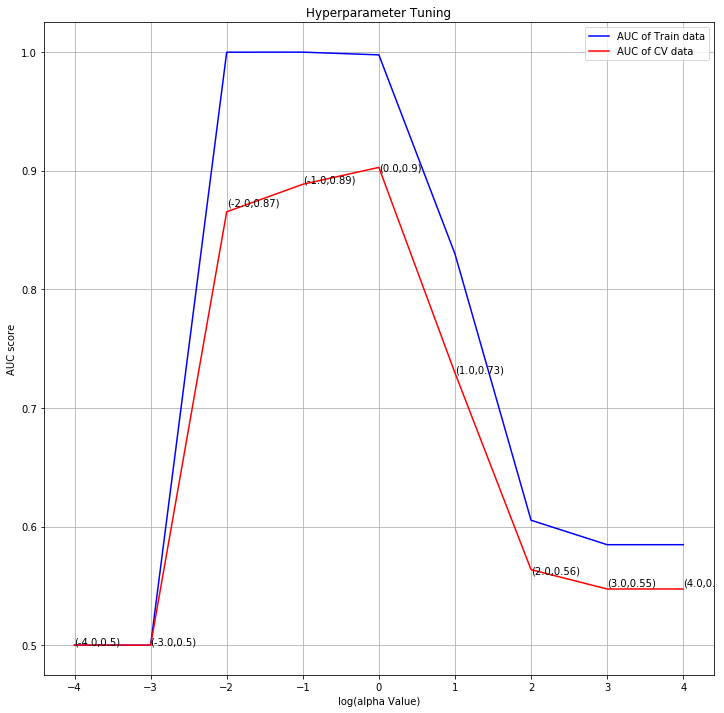

In [251]:
# auc_score plotting

auc_score(alpha_value=log_alpha,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose alpha=1, we get auc_score=0.90

In [252]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
class_return,fi_bow=best_LK(penalty="l2",best_alpha=1,train_vector=bow_train_vec1_std,train_label=y_train,\
                               test_vector=bow_test_vec1_std,test_label=y_test)

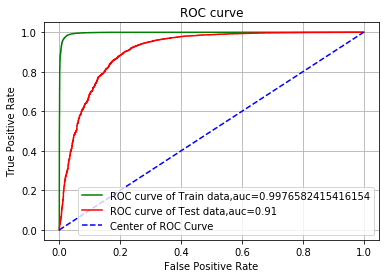

In [253]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

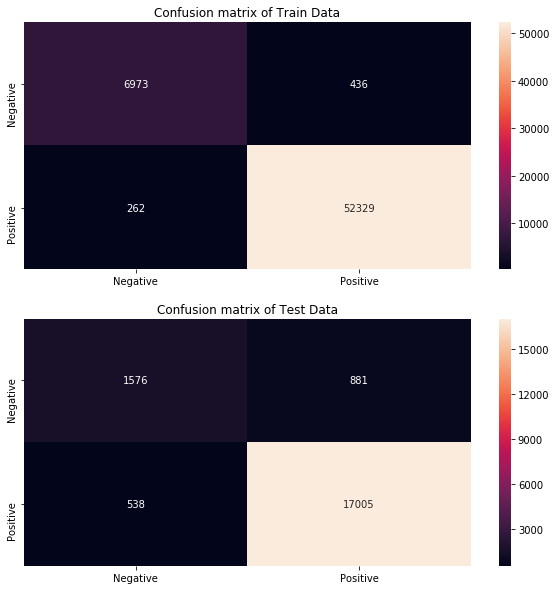

In [254]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=1) on model, we get auc score of future unseen data is 0.91

#### 6.2.2 Linear kernel using TFIDF

In [255]:
# Data standardization

tfidf_train_vec1_std=data_std.fit_transform(tfidf_train_vec1)
tfidf_cv_vec1_std=data_std.transform(tfidf_cv_vec1)
tfidf_test_vec1_std=data_std.transform(tfidf_test_vec1)

In [256]:
# Hyperparameter tuning

auc_train,auc_cv=linear_kernal(penalty="l2",alpha=alpha,train_vector=tfidf_train_vec1_std,train_label=y_train, \
                                             cv_vector=tfidf_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.17it/s]


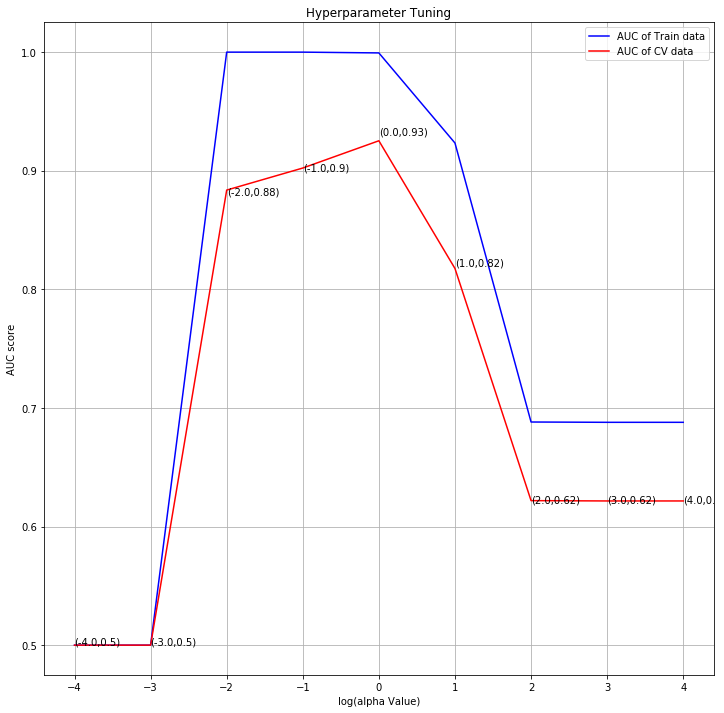

In [257]:
# auc_score plotting

auc_score(alpha_value=log_alpha,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose alpha=1, we get auc_score=0.93

In [258]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
class_return,fi_tfidf=best_LK(penalty="l2",best_alpha=1,train_vector=tfidf_train_vec1_std,train_label=y_train,\
                               test_vector=tfidf_test_vec1_std,test_label=y_test)

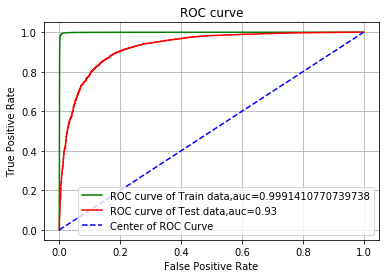

In [259]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

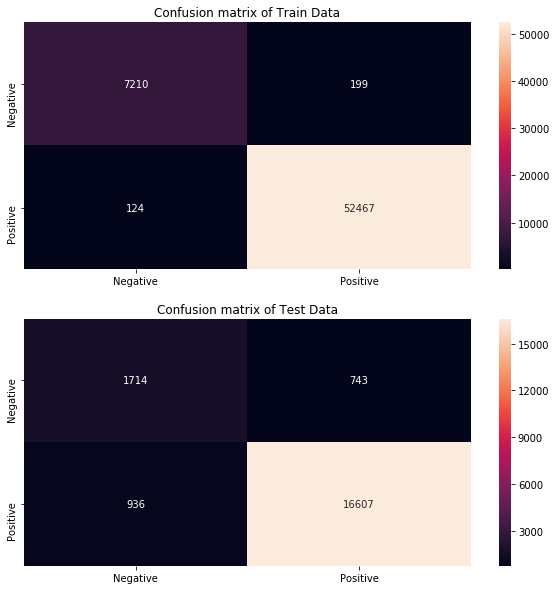

In [260]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=1) on model, we get auc score of future unseen data is 0.93

#### 6.2.3 Linear kernel using Avg W2V

In [261]:
# Data standardization
data_std=StandardScaler(with_mean=True)
avg_w2v_train_vec1_std=data_std.fit_transform(avg_w2v_train)
avg_w2v_cv_vec1_std=data_std.transform(avg_w2v_cv)
avg_w2v_test_vec1_std=data_std.transform(avg_w2v_test)

In [262]:
# Hyperparameter tuning

auc_train,auc_cv=linear_kernal(penalty="l2",alpha=alpha,train_vector=avg_w2v_train_vec1_std,train_label=y_train, \
                                             cv_vector=avg_w2v_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.47it/s]


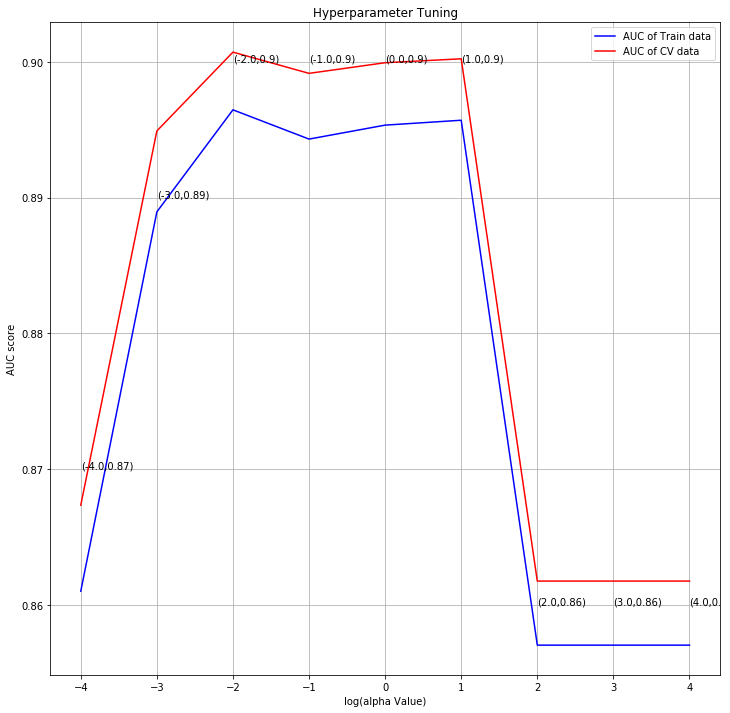

In [263]:
# auc_score plotting

auc_score(alpha_value=log_alpha,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose alpha=0.01, we get auc_score=0.90

In [264]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
class_return,fi=best_LK(penalty="l2",best_alpha=0.01,train_vector=avg_w2v_train_vec1_std,train_label=y_train,\
                               test_vector=avg_w2v_test_vec1_std,test_label=y_test)

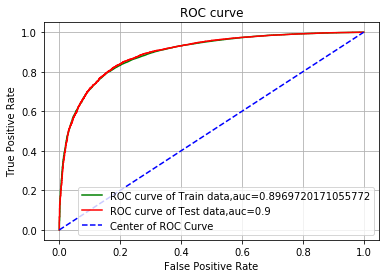

In [265]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

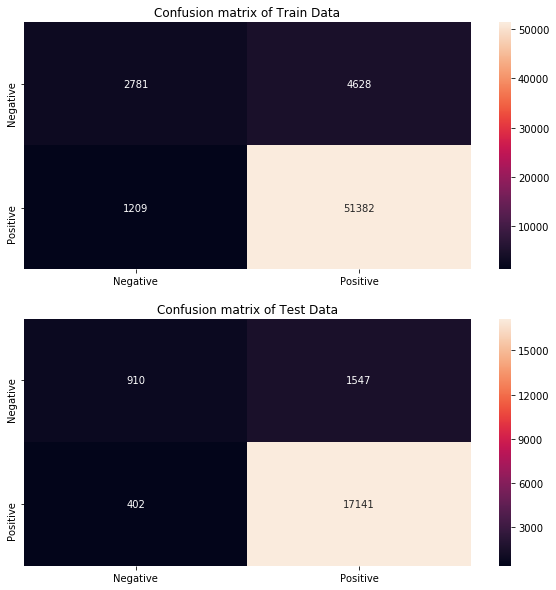

In [266]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=0.01) on model, we get auc score of future unseen data is 0.90

#### 6.2.4 Linear kernel using TFIDF W2V

In [267]:
# Data standardization
data_std=StandardScaler(with_mean=True)
tfidf_w2v_train_vec1_std=data_std.fit_transform(tfidf_w2v_train)
tfidf_w2v_cv_vec1_std=data_std.transform(tfidf_w2v_cv)
tfidf_w2v_test_vec1_std=data_std.transform(tfidf_w2v_test)

In [268]:
# Hyperparameter tuning

auc_train,auc_cv=linear_kernal(penalty="l2",alpha=alpha,train_vector=tfidf_w2v_train_vec1_std,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.02it/s]


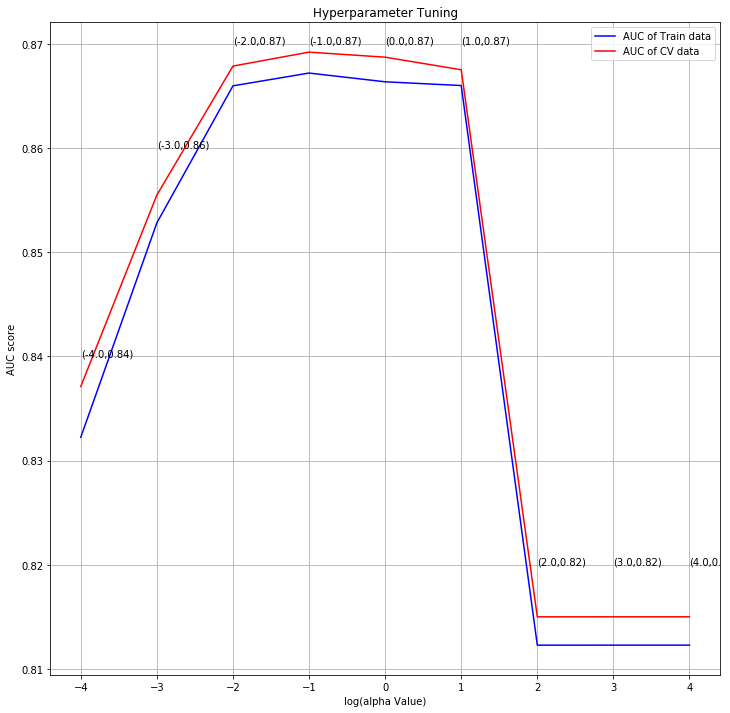

In [269]:
# auc_score plotting

auc_score(alpha_value=log_alpha,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose alpha=1, we get auc_score=0.87

In [270]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
class_return,fi=best_LK(penalty="l2",best_alpha=1,train_vector=tfidf_w2v_train_vec1_std,train_label=y_train,\
                               test_vector=tfidf_w2v_test_vec1_std,test_label=y_test)

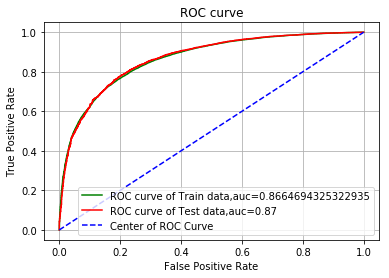

In [271]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

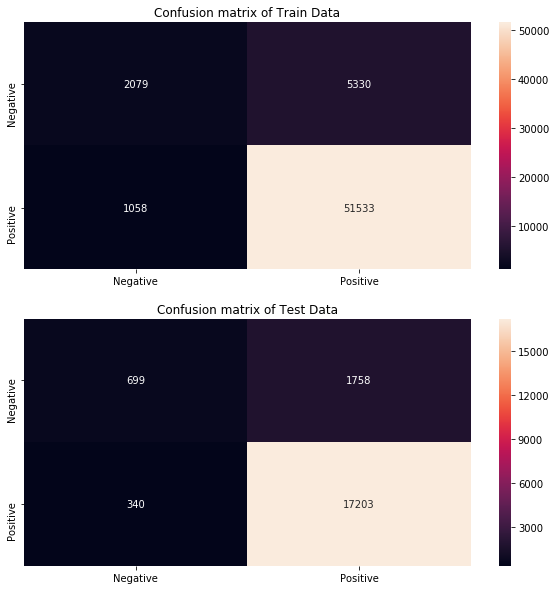

In [272]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=1) on model, we get auc score of future unseen data is 0.87

#### 6.3 Linear Kernel using L1 regularization

#### 6.3.1 Linear Kernal using BOW

In [273]:
# Data standardization
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

In [274]:
data_std=StandardScaler(with_mean=False)
bow_train_vec1_std=data_std.fit_transform(bow_train_vec1)
bow_cv_vec1_std=data_std.transform(bow_cv_vec1)
bow_test_vec1_std=data_std.transform(bow_test_vec1)

In [275]:
alpha=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [276]:
# Hyperparameter tuning

auc_train,auc_cv=linear_kernal(penalty="l1",alpha=alpha,train_vector=bow_train_vec1_std,train_label=y_train, \
                                             cv_vector=bow_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.53it/s]


In [277]:
log_alpha=[]
for i in alpha:
    log_alpha.append(math.log10(i))
log_alpha

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

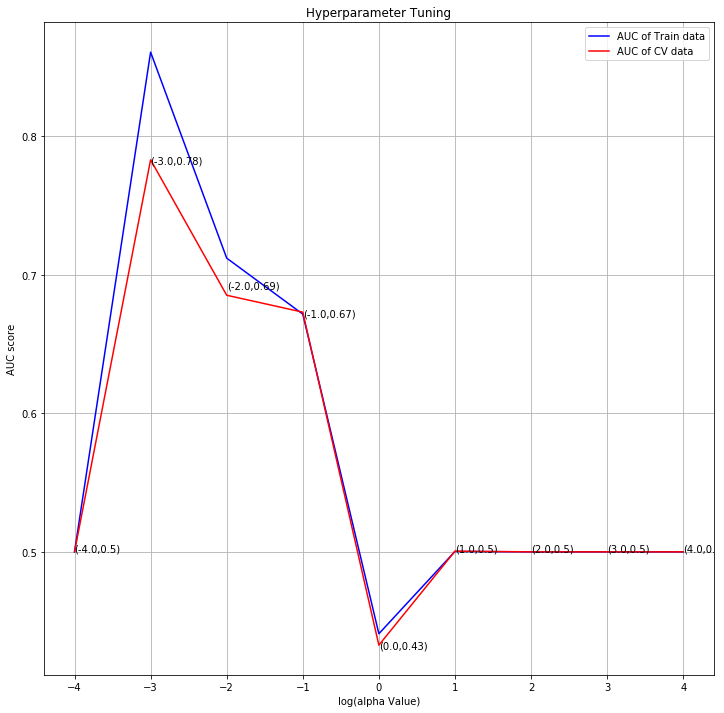

In [278]:
# auc_score plotting

auc_score(alpha_value=log_alpha,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose alpha=0.001, we get auc_score=0.78

In [279]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
class_return,fi=best_LK(penalty="l1",best_alpha=0.001,train_vector=bow_train_vec1_std,train_label=y_train,\
                               test_vector=bow_test_vec1_std,test_label=y_test)

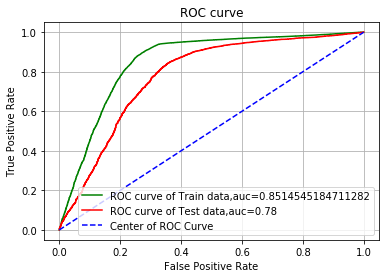

In [280]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

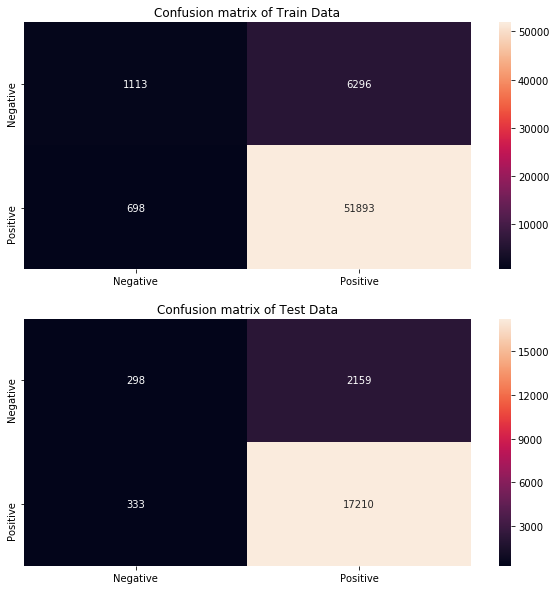

In [281]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=0.001) on model, we get auc score of future unseen data is 0.78

#### 6.3.2 Linear kernel using TFIDF

In [282]:
# Data standardization

tfidf_train_vec1_std=data_std.fit_transform(tfidf_train_vec1)
tfidf_cv_vec1_std=data_std.transform(tfidf_cv_vec1)
tfidf_test_vec1_std=data_std.transform(tfidf_test_vec1)

In [283]:
# Hyperparameter tuning

auc_train,auc_cv=linear_kernal(penalty="l1",alpha=alpha,train_vector=tfidf_train_vec1_std,train_label=y_train, \
                                             cv_vector=tfidf_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  2.08it/s]


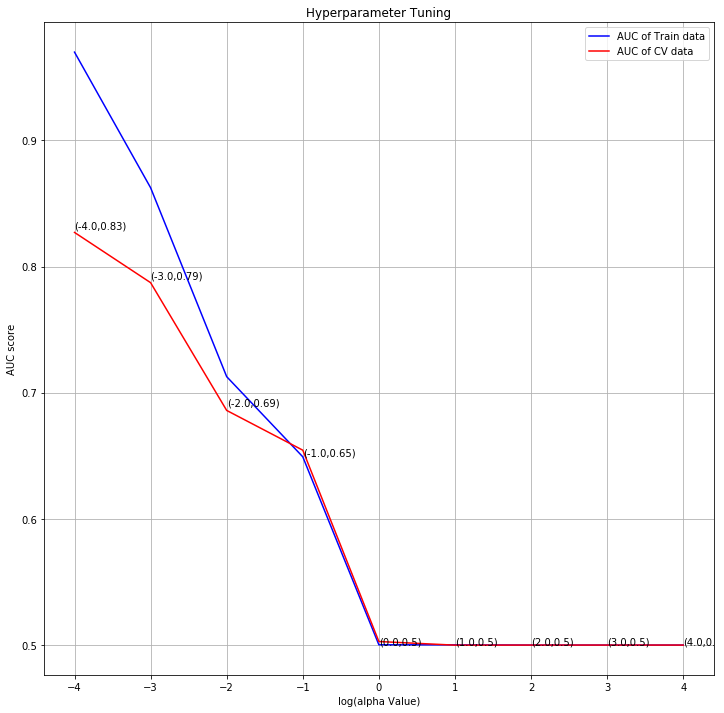

In [284]:
# auc_score plotting

auc_score(alpha_value=log_alpha,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose alpha=0.0001, we get auc_score=0.83

In [285]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
class_return,fi=best_LK(penalty="l1",best_alpha=0.0001,train_vector=tfidf_train_vec1_std,train_label=y_train,\
                               test_vector=tfidf_test_vec1_std,test_label=y_test)

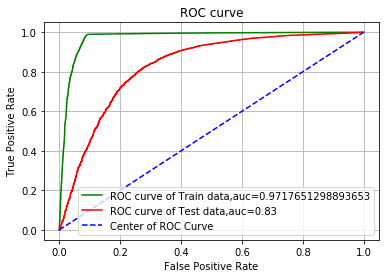

In [286]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

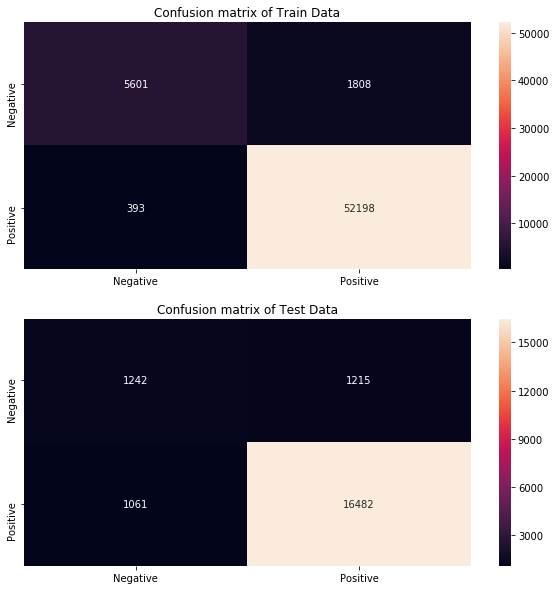

In [287]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=0.0001) on model, we get auc score of future unseen data is 0.83

#### 6.3.3 Linear kernel using Avg W2V

In [288]:
# Data standardization
data_std=StandardScaler(with_mean=True)
avg_w2v_train_vec1_std=data_std.fit_transform(avg_w2v_train)
avg_w2v_cv_vec1_std=data_std.transform(avg_w2v_cv)
avg_w2v_test_vec1_std=data_std.transform(avg_w2v_test)

In [289]:
# Hyperparameter tuning

auc_train,auc_cv=linear_kernal(penalty="l1",alpha=alpha,train_vector=avg_w2v_train_vec1_std,train_label=y_train, \
                                             cv_vector=avg_w2v_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.55it/s]


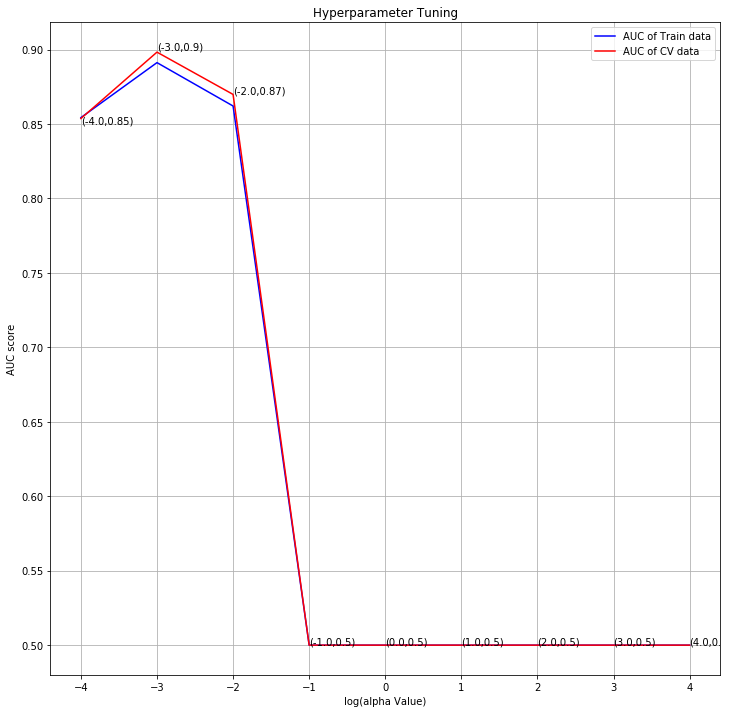

In [290]:
# auc_score plotting

auc_score(alpha_value=log_alpha,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose alpha=0.001, we get auc_score=0.90

In [291]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
class_return,fi=best_LK(penalty="l1",best_alpha=0.001,train_vector=avg_w2v_train_vec1_std,train_label=y_train,\
                               test_vector=avg_w2v_test_vec1_std,test_label=y_test)

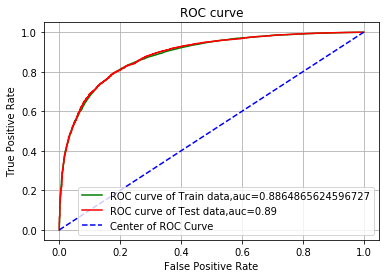

In [292]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

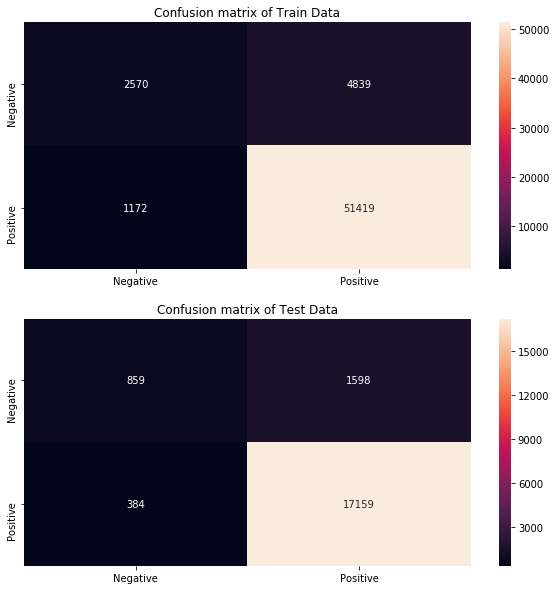

In [293]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=0.001) on model, we get auc score of future unseen data is 0.89

#### 6.3.4 Linear kernel using TFIDF W2V

In [294]:
# Data standardization
data_std=StandardScaler(with_mean=True)
tfidf_w2v_train_vec1_std=data_std.fit_transform(tfidf_w2v_train)
tfidf_w2v_cv_vec1_std=data_std.transform(tfidf_w2v_cv)
tfidf_w2v_test_vec1_std=data_std.transform(tfidf_w2v_test)

In [295]:
# Hyperparameter tuning

auc_train,auc_cv=linear_kernal(penalty="l1",alpha=alpha,train_vector=tfidf_w2v_train_vec1_std,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_vec1_std,cv_label=y_cv)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.02it/s]


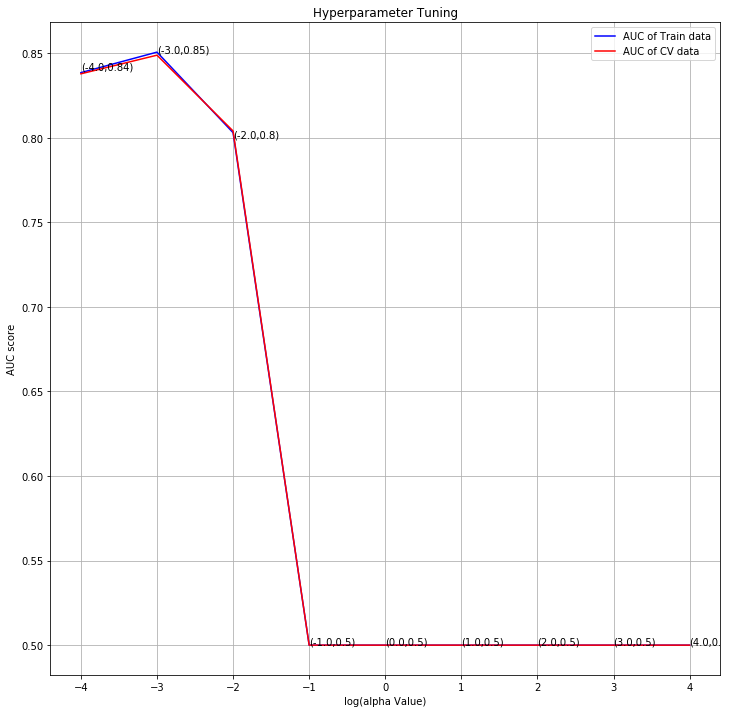

In [296]:
# auc_score plotting

auc_score(alpha_value=log_alpha,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose alpha=0.001, we get auc_score=0.85

In [297]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
class_return,fi=best_LK(penalty="l1",best_alpha=0.001,train_vector=tfidf_w2v_train_vec1_std,train_label=y_train,\
                               test_vector=tfidf_w2v_test_vec1_std,test_label=y_test)

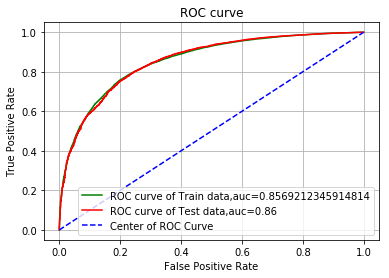

In [298]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

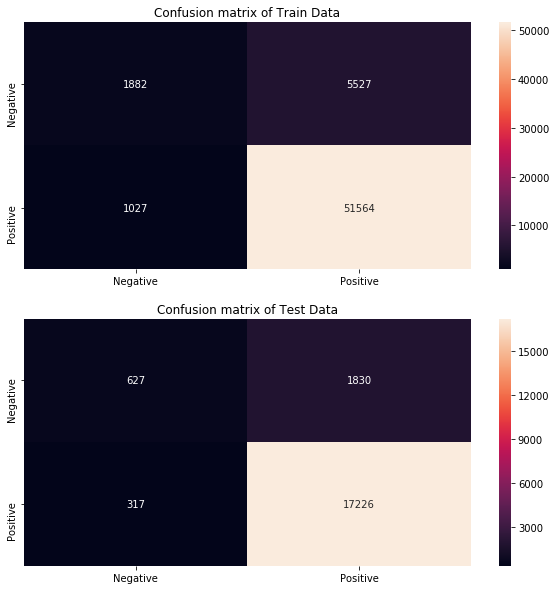

In [299]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (alpha=0.001) on model, we get auc score of future unseen data is 0.86

#### 6.4 Linear Kernel SVM Model Observations

In [300]:
# References
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

In [568]:
x = PrettyTable()

x.field_names = ["Vectorizer","Regularization", "Model", "Hyperparameter", "AUC"]

x.add_row(["BOW","l2","Linear Kernal SVM",1,0.91])
x.add_row(["TFIDF","l2","Linear Kernal SVM",1,0.93])
x.add_row(["Avg W2V","l2","Linear Kernal SVM",0.01,0.90])
x.add_row(["TFIDF W2V","l2","Linear Kernal SVM",1,0.87])

x.add_row(["BOW","l1","Linear Kernal SVM",0.001,0.78])
x.add_row(["TFIDF","l1","Linear Kernal SVM",0.0001,0.83])
x.add_row(["Avg W2V","l1","Linear Kernal SVM",0.001,0.89])
x.add_row(["TFIDF W2V","l1","Linear Kernal SVM",0.001,0.86])
print(x)

+------------+----------------+-------------------+----------------+------+
| Vectorizer | Regularization |       Model       | Hyperparameter | AUC  |
+------------+----------------+-------------------+----------------+------+
|    BOW     |       l2       | Linear Kernal SVM |       1        | 0.91 |
|   TFIDF    |       l2       | Linear Kernal SVM |       1        | 0.93 |
|  Avg W2V   |       l2       | Linear Kernal SVM |      0.01      | 0.9  |
| TFIDF W2V  |       l2       | Linear Kernal SVM |       1        | 0.87 |
|    BOW     |       l1       | Linear Kernal SVM |     0.001      | 0.78 |
|   TFIDF    |       l1       | Linear Kernal SVM |     0.0001     | 0.83 |
|  Avg W2V   |       l1       | Linear Kernal SVM |     0.001      | 0.89 |
| TFIDF W2V  |       l1       | Linear Kernal SVM |     0.001      | 0.86 |
+------------+----------------+-------------------+----------------+------+


* Linear Kernel SVM model using L2 regularization gives better result compare to L1 regularization.
* TFIDF vectorizer gives better result compared to other vectorizers in L2 Regularization.
* Avg W2V vectorizer gives better result compared to other vectorizers in L1 Regularization.

### 7. RBF Kernal SVM

#### 7.1 Creating function for RBF Kernel

In [302]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict
# https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV#sklearn.calibration.
    #CalibratedClassifierCV.predict_proba
# ROC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# ROC_AUC_CURVE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
# AUC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc
# CONFUSION_MATRIX:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import math

In [304]:
# References for Python Functions:
# https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/function-arguments/
# https://www.geeksforgeeks.org/functions-in-python/
# https://www.geeksforgeeks.org/g-fact-41-multiple-return-values-in-python/

# Fuction for Hyper parameter Tuning

def RBF_kernal(**para):
    
    auc_train=[]
    auc_cv=[]
    
    for i in tqdm(para["c"]):
        model=SVC(C=i)
        model.fit(para["train_vector"],para['train_label'])
        clf=CalibratedClassifierCV(model,method="sigmoid",cv="prefit")
        clf.fit(para["train_vector"],para['train_label'])
        
    # Prediction of training data
    
        train_proba=clf.predict_proba(para["train_vector"])
        train=roc_auc_score(para["train_label"],train_proba[:,1])
        auc_train.append(train)
    
    # Prediction of cv data
    
        cv_proba=clf.predict_proba(para["cv_vector"])
        cv=roc_auc_score(para["cv_label"],cv_proba[:,1])
        auc_cv.append(cv)
    
    return auc_train,auc_cv

In [307]:
# Function for Apply best hyperparameter

def best_RBF (**para):
    
    # Model training

    model=SVC(C=para["best_c"])
    model.fit(para["train_vector"],para['train_label'])
    clf=CalibratedClassifierCV(model,method="sigmoid",cv="prefit")
    clf.fit(para["train_vector"],para['train_label'])

    
    # training data
    
    RBF_train_proba=clf.predict_proba(para["train_vector"])
    train_proba=RBF_train_proba
    fpr_train,tpr_train,thres_train=roc_curve(para["train_label"],RBF_train_proba[:,1])
    auc_train=roc_auc_score(para["train_label"],RBF_train_proba[:,1])
    
    # test data
    
    RBF_test_proba=clf.predict_proba(para["test_vector"])
    test_proba=RBF_test_proba
    fpr_test,tpr_test,thres_test=roc_curve(para["test_label"],RBF_test_proba[:,1])
    auc_test=roc_auc_score(para["test_label"],RBF_test_proba[:,1])
    
    return train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test

In [308]:
# References
# https://stackoverflow.com/questions/6282058/writing-numerical-values-on-the-plot-with-matplotlib
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html

# Fuction for plotting AUC values

def auc_score(**para):
    plt.close()
    fig = plt.figure(1,figsize=(12,12))
    ax = fig.add_subplot(111)
    plt.plot(para["c_value"],para["auc_train"],"b",label="AUC of Train data")
    plt.plot(para["c_value"],para["auc_cv"],"r",label="AUC of CV data")
    plt.xlabel("log(c Value)")
    plt.ylabel("AUC score")
    plt.title("Hyperparameter Tuning")
    plt.grid()
    plt.legend()
    y=[]
    for x in para["auc_cv"]:
        y.append(round(x,2))
    for i,j in zip(para["c_value"],y):
        ax.annotate("("+str(i)+","+str(j)+")",xy=(i,j),clip_on=True)
    plt.show()

In [309]:
# Fuction for plotting ROC curve

def roc_model(**para):
    plt.close()
    plt.plot(para["fpr_train"],para["tpr_train"],"green",label="ROC curve of Train data,auc="+para['text1'])
    plt.plot(para["fpr_test"],para["tpr_test"],"red",label="ROC curve of Test data,auc="+para['text2'])
    plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.title("ROC curve")
    plt.legend()
    plt.show()

In [310]:
# References
# confusion matrix of Train and Test data
# https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities?rq=1
# plotting confusion matrix: https://seaborn.pydata.org/generated/seaborn.heatmap.html


# Function for confusion matrix

def cm_plot(**para):
    #  confusion matrix of training data
    train_pred_cm=np.argmax(para["train_proba"],axis=1)
    train_confusion_matrix=confusion_matrix(para["train_label"],train_pred_cm,labels=[0,1])
    train_cm=pd.DataFrame(train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

    # confusion matrix of test data

    test_pred_cm=np.argmax(para["test_proba"],axis=1)
    test_confusion_matrix=confusion_matrix(para["test_label"],test_pred_cm,labels=[0,1])
    test_cm=pd.DataFrame(test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
    
    plt.close()
    plt.figure(1,figsize=(10,10))
    plt.subplot(211)
    sns.heatmap(train_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Train Data")
    plt.subplot(212)
    sns.heatmap(test_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Test Data")
    plt.show()

#### 7.2 RBF Kernel

#### 7.2.1 RBF Kernal using BOW

In [311]:
# Data standardization
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from sklearn.preprocessing import StandardScaler

In [312]:
data_std=StandardScaler(with_mean=False)
bow_train_vec2_std=data_std.fit_transform(bow_train_vec2)
bow_cv_vec2_std=data_std.transform(bow_cv_vec2)
bow_test_vec2_std=data_std.transform(bow_test_vec2)

In [313]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [315]:
# Hyperparameter tuning

auc_train,auc_cv=RBF_kernal(c=c,train_vector=bow_train_vec2_std,train_label=y_train_1, \
                                             cv_vector=bow_cv_vec2_std,cv_label=y_cv_1)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [49:43<00:00, 397.11s/it]


In [317]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

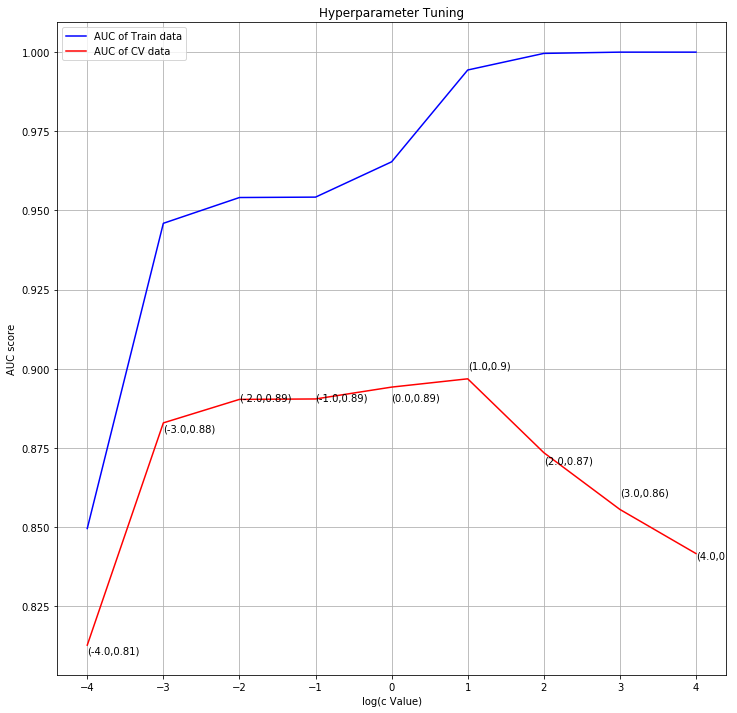

In [318]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose c=10, we get auc_score=0.90

In [319]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_RBF(best_c=10,train_vector=bow_train_vec2_std,train_label=y_train_1,\
                               test_vector=bow_test_vec2_std,test_label=y_test_1)

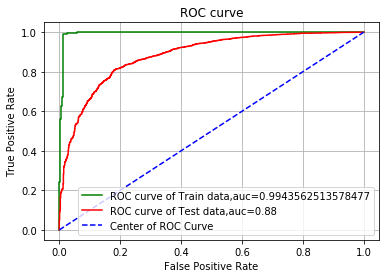

In [320]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

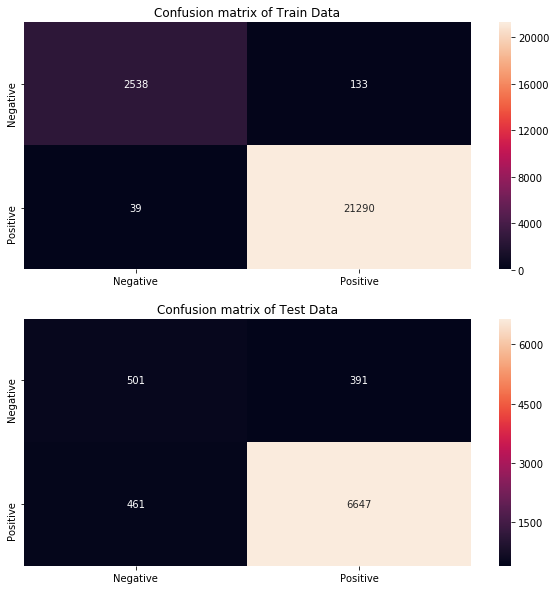

In [322]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train_1,test_proba=test_proba,test_label=y_test_1)

##### Observation:

* When we applying best hyperparameter (c=10) on model, we get auc score of future unseen data is 0.88

#### 7.2.2 RBF kernel using TFIDF

In [323]:
# Data standardization

tfidf_train_vec2_std=data_std.fit_transform(tfidf_train_vec2)
tfidf_cv_vec2_std=data_std.transform(tfidf_cv_vec2)
tfidf_test_vec2_std=data_std.transform(tfidf_test_vec2)

In [326]:
# Hyperparameter tuning

auc_train,auc_cv=RBF_kernal(c=c,train_vector=tfidf_train_vec2_std,train_label=y_train_1, \
                                             cv_vector=tfidf_cv_vec2_std,cv_label=y_cv_1)

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:06:15<00:00, 604.00s/it]


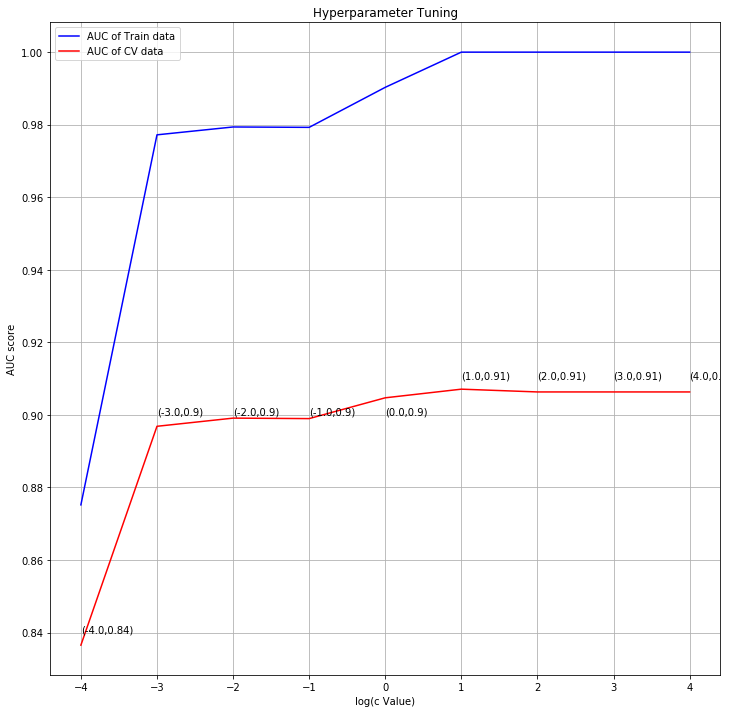

In [328]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose c=1, we get auc_score=0.90

In [376]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_RBF(best_c=1,train_vector=tfidf_train_vec2_std,train_label=y_train_1,\
                               test_vector=tfidf_test_vec2_std,test_label=y_test_1)

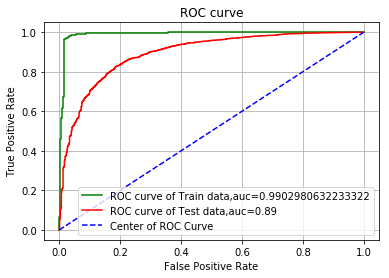

In [377]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

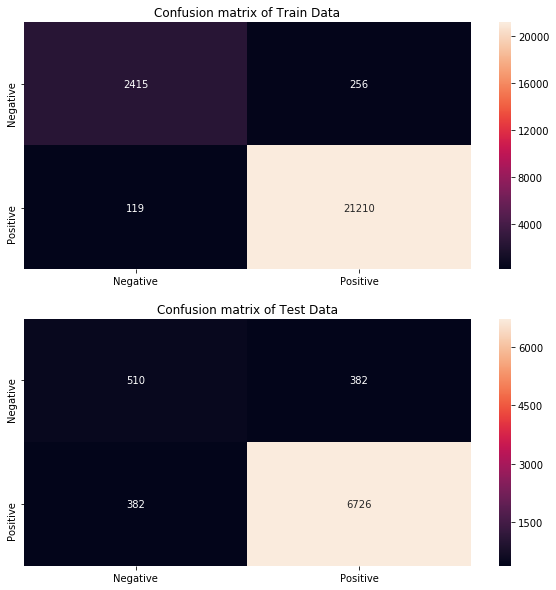

In [378]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train_1,test_proba=test_proba,test_label=y_test_1)

##### Observation:

* When we applying best hyperparameter (c=1) on model, we get auc score of future unseen data is 0.89

#### 7.2.3 RBF kernel using Avg W2V

In [333]:
# Data standardization
data_std=StandardScaler(with_mean=True)
avg_w2v_train_vec2_std=data_std.fit_transform(avg_w2v_train_1)
avg_w2v_cv_vec2_std=data_std.transform(avg_w2v_cv_1)
avg_w2v_test_vec2_std=data_std.transform(avg_w2v_test_1)

In [334]:
# Hyperparameter tuning

auc_train,auc_cv=RBF_kernal(c=c,train_vector=avg_w2v_train_vec2_std,train_label=y_train_1, \
                                             cv_vector=avg_w2v_cv_vec2_std,cv_label=y_cv_1)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [16:38<00:00, 163.34s/it]


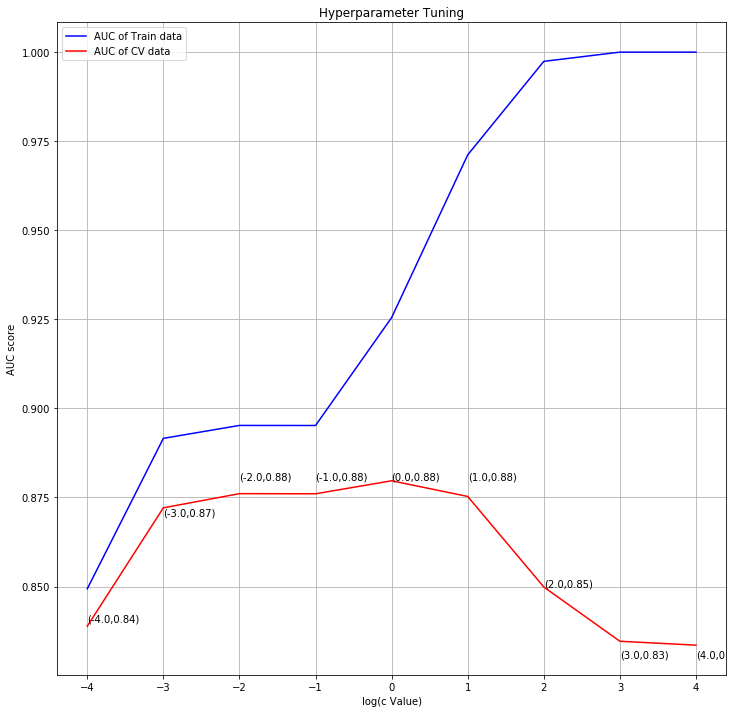

In [335]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.88

In [337]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_RBF(best_c=0.01,train_vector=avg_w2v_train_vec2_std,train_label=y_train_1,\
                               test_vector=avg_w2v_test_vec2_std,test_label=y_test_1)

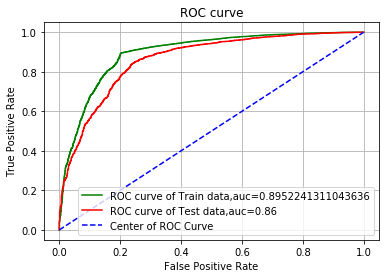

In [338]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

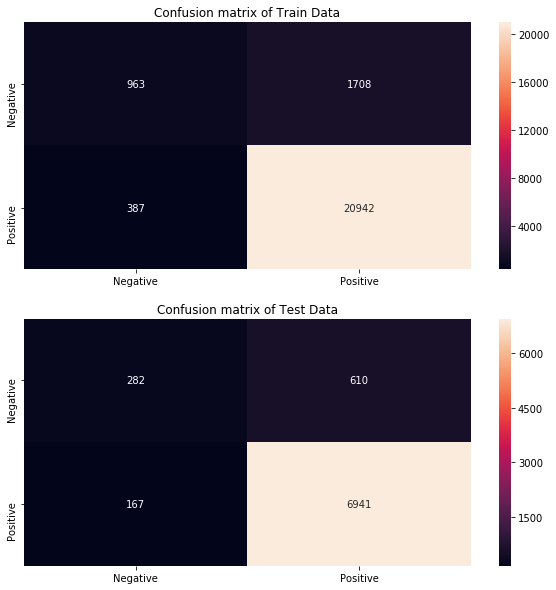

In [339]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train_1,test_proba=test_proba,test_label=y_test_1)

##### Observation:

* When we applying best hyperparameter (c=0.01) on model, we get auc score of future unseen data is 0.86

#### 7.2.4 RBF kernel using TFIDF W2V

In [346]:
# Data standardization
data_std=StandardScaler(with_mean=False)
tfidf_w2v_train_vec2_std=data_std.fit_transform(tfidf_w2v_train_1)
tfidf_w2v_cv_vec2_std=data_std.transform(tfidf_w2v_cv_1)
tfidf_w2v_test_vec2_std=data_std.transform(tfidf_w2v_test_1)

In [354]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/44727793/imputer-mean-strategy-removes-nan-instead-of-replacing

from sklearn.impute import SimpleImputer

In [355]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_train_vec2_std=imp.fit_transform(tfidf_w2v_train_vec2_std)
tfidf_w2v_cv_vec2_std=imp.fit_transform(tfidf_w2v_cv_vec2_std)
tfidf_w2v_test_vec2_std=imp.fit_transform(tfidf_w2v_test_vec2_std)

In [356]:
# Hyperparameter tuning

auc_train,auc_cv=RBF_kernal(c=c,train_vector=tfidf_w2v_train_vec2_std,train_label=y_train_1, \
                                             cv_vector=tfidf_w2v_cv_vec2_std,cv_label=y_cv_1)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [20:04<00:00, 215.21s/it]


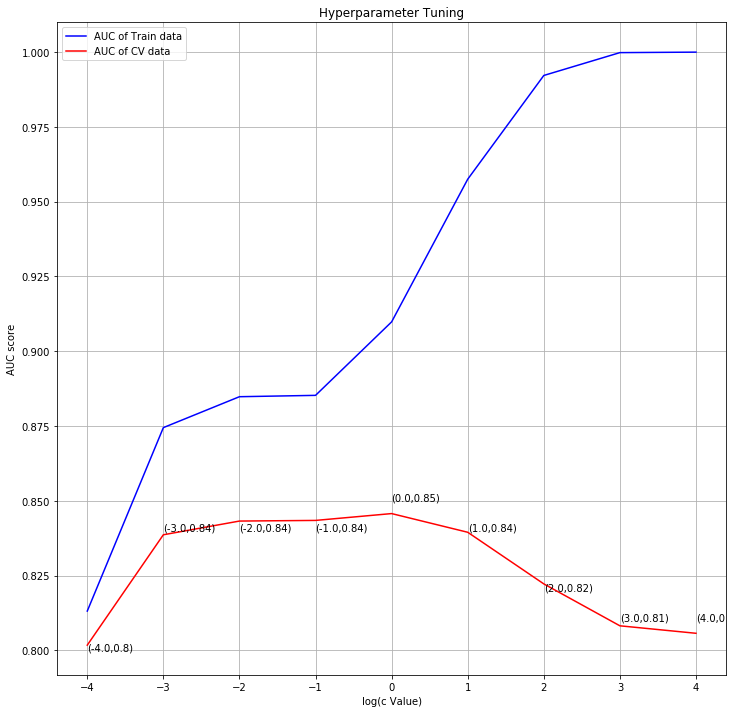

In [357]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose c=0.01, we get auc_score=0.84

In [391]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_RBF(best_c=0.01,train_vector=tfidf_w2v_train_vec2_std,train_label=y_train_1,\
                               test_vector=tfidf_w2v_test_vec2_std,test_label=y_test_1)

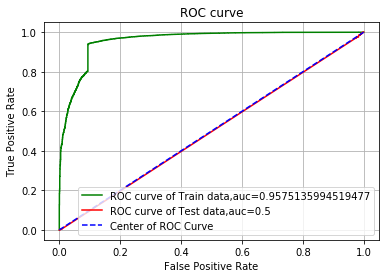

In [392]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

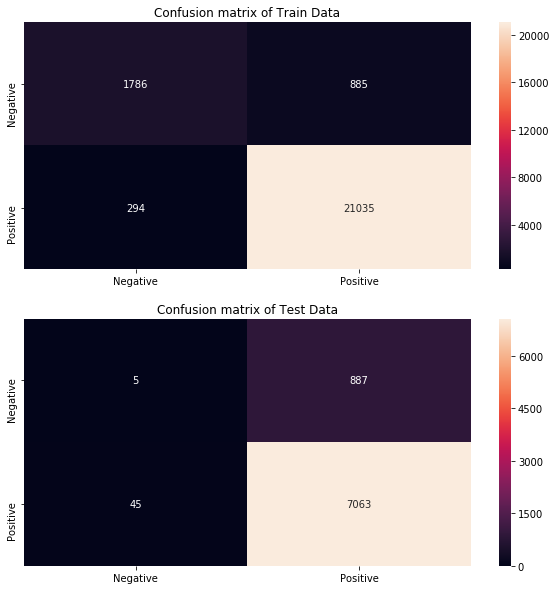

In [393]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train_1,test_proba=test_proba,test_label=y_test_1)

##### Observation:

* When we applying best hyperparameter (c=0.01) on model, we get auc score of future unseen data is 0.50
* TFIDF W2V gives Random model we can improve that model further by using Feature Engineering and also improve by model by choosing more number datapoints.

#### 7.3 RBF Kernel SVM Model Observations

In [300]:
# References
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

In [567]:
y = PrettyTable()

y.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

y.add_row(["BOW","RBF Kernal SVM",10,0.88])
y.add_row(["TFIDF","RBF  Kernal SVM",1,0.89])
y.add_row(["Avg W2V","RBF  Kernal SVM",0.01,0.86])
y.add_row(["TFIDF W2V","RBF  Kernal SVM",0.01,0.50])

print(y)

+------------+-----------------+----------------+------+
| Vectorizer |      Model      | Hyperparameter | AUC  |
+------------+-----------------+----------------+------+
|    BOW     |  RBF Kernal SVM |       10       | 0.88 |
|   TFIDF    | RBF  Kernal SVM |       1        | 0.89 |
|  Avg W2V   | RBF  Kernal SVM |      0.01      | 0.86 |
| TFIDF W2V  | RBF  Kernal SVM |      0.01      | 0.5  |
+------------+-----------------+----------------+------+


* TFIDF vectorizer gives better result compared to other vectorizers.
* TFIDF W2V gives Random model we can improve that model further by using Feature Engineering and also improve by model by choosing more number datapoints.

### 8. Feature Importance

* Feature importance on TFIDF and BOW of Linear SVM

#### 8.1 Pertubation test on BOW

* The pertubation test is used to find the multi col-linearity of the features.

In [428]:
# References
# To find the indices of the non zero elements in sparse matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.find.html
# To generate the the random noise using Normal Distribution
# https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.normal.html
# https://github.com/cyanamous/

import scipy as ss

###### Before adding noise weight  vector (w)

In [429]:
# before adding noise

model=SGDClassifier(penalty="l2",alpha=1)
model.fit(bow_train_vec1_std,y_train)
w= model.coef_

In [430]:
w.shape

(1, 79401)

In [431]:
w

array([[ 0.00048057,  0.00266699, -0.00036497, ...,  0.00074954,
         0.00013772,  0.00031431]])

###### After adding noise weight vector (w1)

In [432]:
# adding noise (epsilon)

bow_new=bow_train_vec1_std

# finding the indices of the non zero elements in sparse matrix

row,column,value=ss.sparse.find(bow_new)

In [433]:
value.shape

(2982287,)

In [434]:
# generate noise using normal distribution

size_noise=value.size
noise=np.random.normal(loc=0,scale=0.01,size=size_noise)

In [435]:
# adding noise

bow_new[row,column]=bow_new[row,column]+ noise

###### Finding w' using Linear Kernal SVM model

In [436]:
model=SGDClassifier(penalty="l2",alpha=1)
model.fit(bow_new,y_train)
w1= model.coef_

###### Find the number of non-zero elements in weight vector (w and w1)

In [443]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print("non zero elements in w")
print("="*125)
print(np.count_nonzero(w))
print(" ")
print("non zero elements in w1")
print("="*125)
print(np.count_nonzero(w1))

non zero elements in w
74137
 
non zero elements in w1
74081


###### Add a small noise (10^6) in weight vectors (w &w1) to avoid division by error

In [444]:
x=w+0.000001
y=w1+0.000001

###### % change of weight vectors

$\ delta=(| (x-y)/x |) * 100 $

In [445]:
x[0,7000:7010]

array([0.000001, 0.001926, 0.001461, 0.000001, 0.000366, 0.000001,
       -0.001332, 0.000986, -0.000865, 0.000273])

In [446]:
y[0,7000:7010]

array([0.000274, 0.002118, 0.001461, 0.000367, 0.000731, 0.000001,
       -0.001666, 0.000740, -0.000577, 0.000273])

In [447]:
delta= abs((x-y)/x)*100

In [448]:
delta

array([[66.568692, 12.495533, 100.371979, ..., 24.939822, 0.176788,
        0.002852]])

In [449]:
# sort delta as a ascending order
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.sort.html

delta1=delta[0]
delta_new=np.sort(delta1)

In [450]:
delta_new.shape

(79401,)

In [451]:
delta_new

array([0.000000, 0.000000, 0.000000, ..., 167647.048587, 223528.300164,
       309737.581833])

###### Compute percentile

In [452]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html
# Print array values from scientific notation to numerical value 
# https://stackoverflow.com/questions/32635911/convert-elements-of-an-array-from-scientific-notation-to-decimal-notation-in-pyt

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
percen_list=[10,20,30,40,50,60,70,80,90,100]

In [453]:
percen_value=np.percentile(delta_new,percen_list)

In [454]:
percen_value

array([0.002246, 0.007421, 0.016019, 0.113532, 9.997467, 16.668209,
       25.005922, 49.875012, 99.700964, 309737.581833])

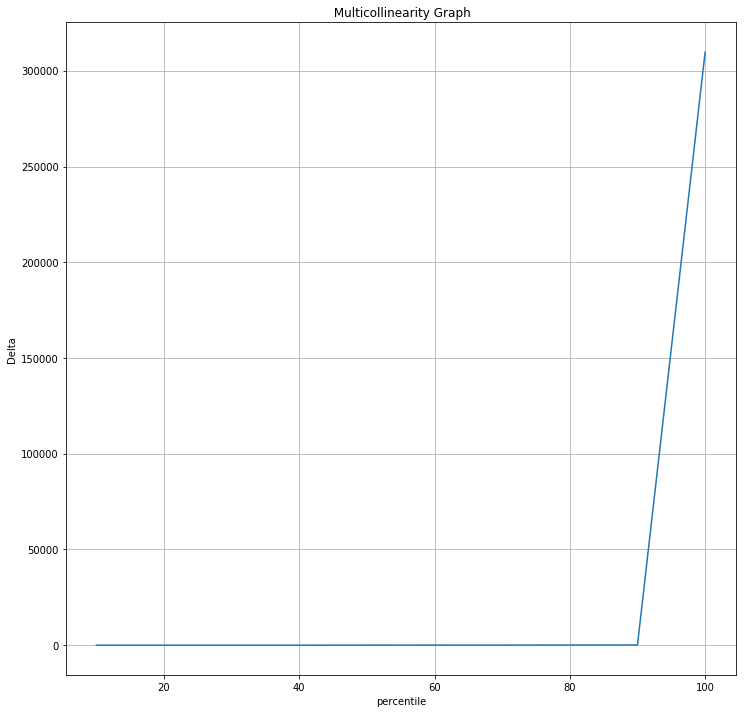

In [455]:
plt.close
plt.figure(figsize=(12,12))
plt.plot(percen_list,percen_value)
plt.grid()
plt.title(" Multicollinearity Graph")
plt.xlabel("percentile")
plt.ylabel("Delta")
plt.show()

###### Observation:

* There is 99 to 100 suddenly values are increased.

In [456]:
# percentile between 99 to 100

percen_list1=[98.9,99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]

In [459]:
percen_value1=np.percentile(delta_new,percen_list1)

In [458]:
percen_value1

array([36516.129808, 36518.194329, 36520.933597, 36744.313027,
       38309.177953, 40958.054898, 44635.237616, 49001.400151,
       54439.477690, 62182.423086, 73036.543695, 309737.581833])

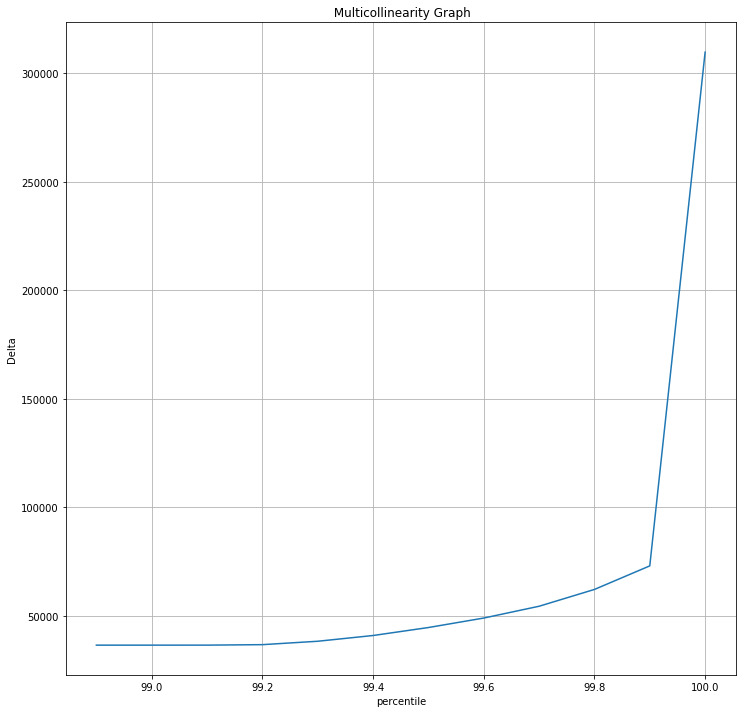

In [460]:
plt.close
plt.figure(figsize=(12,12))
plt.plot(percen_list1,percen_value1)
plt.grid()
plt.title(" Multicollinearity Graph")
plt.xlabel("percentile")
plt.ylabel("Delta")
plt.show()

##### Observation:

* So there is threshold in x axis is 99.6, the corresponded y axis value is 49001.40. So we need to find how many features are above the threshold percentage change. These features are have multicollinear property.

###### Removing Multicollinearity Features

In [461]:
# References
# https://stackoverflow.com/questions/7270321/finding-the-index-of-elements-based-on-a-condition-using-python-list-comprehensi

fi_thres=delta1[np.where(delta1 >= 49001.40)].size

In [462]:
fi_thres

318

* Here we have 318 features are above the threshold, that means 318 features are have Multicollinear property.

In [464]:
fi_thres1=np.where(delta1 >= 49001.40)

In [465]:
fi_thres1[0].shape

(318,)

In [466]:
# Feature Importance Selection

w_fi=np.argsort(w[0])[::-1]

In [467]:
w_fi.shape

(79401,)

In [468]:
p_class=w_fi[0:20]
n_class=w_fi[-21:-1]

In [469]:
# checking whether the multicollinear feature present are not in top 10 features.

for i in p_class:
    for j in fi_thres1[0]:
        if i == j:
            print(j)

In [470]:
for i in n_class:
    for j in fi_thres1[0]:
        if i == j:
            print(j)

###### 8.1.1 Feature names whose  percentage change is above the threshold  (Multicollinearty Features in BOW)

In [474]:
print(np.take(bow_model.get_feature_names(),fi_thres1[0]))

['add skim' 'adopt dog' 'afteral' 'also fruit' 'also natur' 'also offer'
 'amazon littl' 'american brand' 'amidst' 'anymor also' 'approxim minut'
 'arent' 'arriv home' 'back get' 'bad bad' 'bag least' 'bag make'
 'balanc flavor' 'bbq favorit' 'bean well' 'bergin nut' 'better expens'
 'betti lou' 'big easi' 'big green' 'bit soft' 'bolder' 'bottl back'
 'bounc around' 'box gave' 'brand especi' 'bread roll' 'bread turn'
 'brew regular' 'brew way' 'broken small' 'broth' 'browni chocol'
 'buy free' 'buy seed' 'buy via' 'call bold' 'call name' 'came without'
 'campaign' 'candi probabl' 'case daughter' 'case tast' 'cater' 'centr'
 'cereal yet' 'check see' 'chees no' 'chew swallow' 'chew without'
 'chewi bit' 'china green' 'chocol general' 'chocol got' 'chocol well'
 'choic not' 'coffe base' 'cold season' 'combin juic' 'come decaf'
 'come less' 'compani seem' 'concret' 'consid give' 'consum much'
 'contain pack' 'contradict' 'cooki never' 'cost mani' 'crumbl cooki'
 'cup java' 'current drink' 

#### 8.2 Top 20 features in Positive and Negative Class (BOW)

In [475]:
print("Top 20 Positive Features")
print("="*125)
print(np.take(bow_model.get_feature_names(),p_class))
print(" ")
print("Top 20 Negative Features")
print("="*125)
print(np.take(bow_model.get_feature_names(),n_class))

Top 20 Positive Features
['great' 'love' 'best' 'good' 'delici' 'excel' 'favorit' 'tasti' 'perfect'
 'wonder' 'nice' 'easi' 'great product' 'tast great' 'find' 'thank'
 'high recommend' 'dog love' 'enjoy' 'use']
 
Top 20 Negative Features
['bland' 'unfortun' 'not good' 'stale' 'wast' 'not order'
 'realli disappoint' 'return' 'two star' 'would not' 'aw' 'terribl'
 'not purchas' 'threw' 'horribl' 'wast money' 'worst' 'not recommend'
 'not worth' 'not buy']


#### 8.3 Pertubation test on TFIDF

* The pertubation test is used to find the multi col-linearity of the features.

###### Before adding noise weight  vector (w)

In [476]:
# before adding noise

model=SGDClassifier(penalty="l2",alpha=1)
model.fit(tfidf_train_vec1_std,y_train)
w= model.coef_

In [477]:
w.shape

(1, 79401)

In [478]:
w

array([[-0.000324, 0.001131, 0.000919, ..., -0.000062, 0.000201,
        0.000424]])

###### After adding noise weight vector (w1)

In [479]:
# adding noise (epsilon)

tfidf_new=tfidf_train_vec1_std

# finding the indices of the non zero elements in sparse matrix

row,column,value=ss.sparse.find(tfidf_new)

In [480]:
value.shape

(2982287,)

In [481]:
# generate noise using normal distribution

size_noise=value.size
noise=np.random.normal(loc=0,scale=0.01,size=size_noise)

In [482]:
# adding noise

tfidf_new[row,column]=tfidf_new[row,column]+ noise

###### Finding w' using Linear Kernal SVM model

In [483]:
model=SGDClassifier(penalty="l2",alpha=1)
model.fit(tfidf_new,y_train)
w1= model.coef_

###### Find the number of non-zero elements in weight vector (w and w1)

In [484]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print("non zero elements in w")
print("="*125)
print(np.count_nonzero(w))
print(" ")
print("non zero elements in w1")
print("="*125)
print(np.count_nonzero(w1))

non zero elements in w
75939
 
non zero elements in w1
76333


###### Add a small noise (10^6) in weight vectors (w &w1) to avoid division by error

In [485]:
x=w+0.000001
y=w1+0.000001

###### % change of weight vectors

$\ delta=(| (x-y)/x |) * 100 $

In [486]:
x[0,7000:7010]

array([0.000975, 0.001865, 0.000124, 0.000179, 0.000649, 0.000001,
       -0.000800, 0.001179, -0.000843, 0.000977])

In [487]:
y[0,7000:7010]

array([0.000155, 0.002211, 0.000675, 0.000179, 0.000865, 0.000001,
       -0.001381, 0.001825, -0.001319, 0.001669])

In [488]:
delta= abs((x-y)/x)*100

In [489]:
delta

array([[206.607637, 30.687376, 0.013148, ..., 602.031194, 116.426679,
        0.000453]])

In [490]:
# sort delta as a ascending order
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.sort.html

delta1=delta[0]
delta_new=np.sort(delta1)

In [491]:
delta_new.shape

(79401,)

In [492]:
delta_new

array([0.000000, 0.000000, 0.000000, ..., 138118.634281, 146163.008649,
       611577.760187])

###### Compute percentile

In [493]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html
# Print array values from scientific notation to numerical value 
# https://stackoverflow.com/questions/32635911/convert-elements-of-an-array-from-scientific-notation-to-decimal-notation-in-pyt

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
percen_list=[10,20,30,40,50,60,70,80,90,100]

In [494]:
percen_value=np.percentile(delta_new,percen_list)

In [495]:
percen_value

array([0.006672, 0.480154, 5.315857, 10.726172, 16.930400, 24.814678,
       35.899753, 56.484462, 110.644026, 611577.760187])

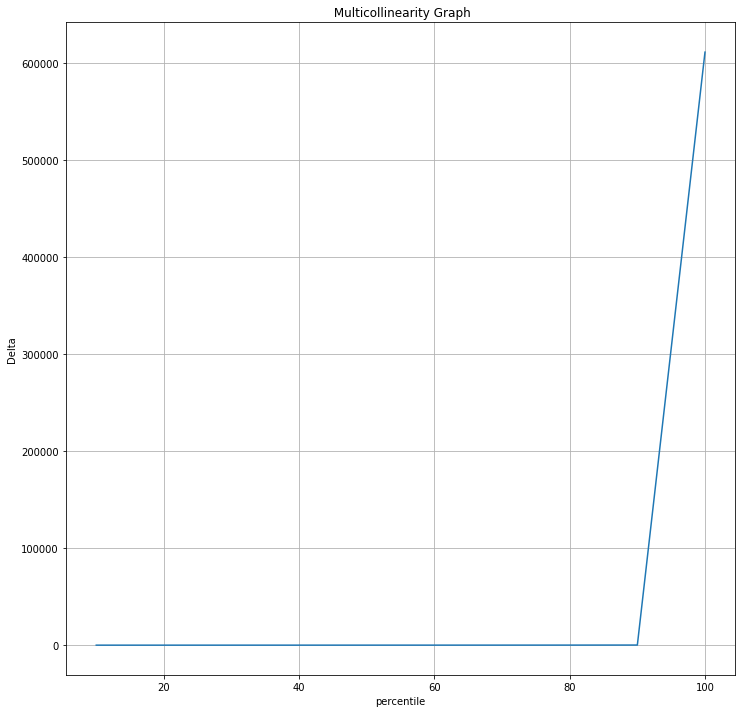

In [496]:
plt.close
plt.figure(figsize=(12,12))
plt.plot(percen_list,percen_value)
plt.grid()
plt.title(" Multicollinearity Graph")
plt.xlabel("percentile")
plt.ylabel("Delta")
plt.show()

###### Observation:

* There is 99 to 100 suddenly values are increased.

In [497]:
# percentile between 99 to 100

percen_list1=[98.9,99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]

In [498]:
percen_value1=np.percentile(delta_new,percen_list1)

In [499]:
percen_value1

array([28352.943749, 28360.105196, 29975.133163, 31379.298769,
       34271.951643, 37045.543687, 39787.758346, 42865.300569,
       46554.387693, 52540.904729, 61456.800169, 611577.760187])

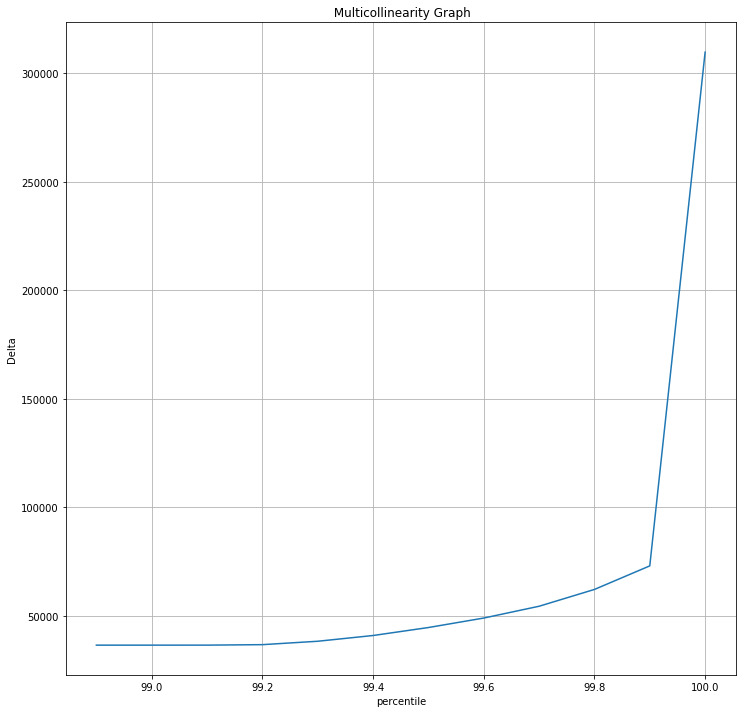

In [460]:
plt.close
plt.figure(figsize=(12,12))
plt.plot(percen_list1,percen_value1)
plt.grid()
plt.title(" Multicollinearity Graph")
plt.xlabel("percentile")
plt.ylabel("Delta")
plt.show()

##### Observation:

* So there is threshold in x axis is 99.6, the corresponded y axis value is 42865.30. So we need to find how many features are above the threshold percentage change. These features are have multicollinear property.

###### Removing Multicollinearity Features

In [500]:
# References
# https://stackoverflow.com/questions/7270321/finding-the-index-of-elements-based-on-a-condition-using-python-list-comprehensi

fi_thres=delta1[np.where(delta1 >= 42865.30)].size

In [501]:
fi_thres

318

* Here we have 318 features are above the threshold, that means 318 features are have Multicollinear property.

In [502]:
fi_thres1=np.where(delta1 >= 42865.30)

In [503]:
fi_thres1[0].shape

(318,)

In [504]:
# Feature Importance Selection

w_fi=np.argsort(w[0])[::-1]

In [505]:
w_fi.shape

(79401,)

In [506]:
p_class=w_fi[0:20]
n_class=w_fi[-21:-1]

In [507]:
# checking whether the multicollinear feature present are not in top 10 features.

for i in p_class:
    for j in fi_thres1[0]:
        if i == j:
            print(j)

In [508]:
for i in n_class:
    for j in fi_thres1[0]:
        if i == j:
            print(j)

###### 8.3.1 Feature names whose  percentage change is above the threshold  (Multicollinearty Features in TFIDF)

In [511]:
print(np.take(tfidf_model.get_feature_names(),fi_thres1[0]))

['abil make' 'absolut divin' 'actual less' 'ad chicken' 'ad list'
 'add everyth' 'add grill' 'add organ' 'add sever' 'afford great'
 'alfalfa meal' 'also absolut' 'also hold' 'also kid' 'alway challeng'
 'amount zing' 'appl blackberri' 'avoderm' 'awar mani' 'back leg'
 'bag varieti' 'bar fiber' 'beauti flower' 'becom famili' 'benefit tea'
 'best year' 'better anyway' 'better said' 'better wheat' 'bit drink'
 'bit eat' 'bit misnom' 'bore drink' 'bowl first' 'box macaroni'
 'brand kettl' 'brand often' 'bring new' 'busi associ' 'buy plus'
 'cake alway' 'cake even' 'carri coupl' 'carri home' 'carri regular'
 'case conveni' 'cereal mani' 'chai black' 'chees meal' 'chicken come'
 'chicken sauc' 'childhood day' 'children year' 'cinnamon cereal'
 'coffe feel' 'come lot' 'compani even' 'consid best' 'contain approxim'
 'cook put' 'coupl teaspoon' 'cut meat' 'daughter drink' 'day right'
 'degre oven' 'delic tast' 'delici cold' 'delici salad' 'delici smoothi'
 'detour' 'diet instead' 'digest easi

#### 8.4 Top 20 features in Positive and Negative Class (TFIDF)

In [510]:
print("Top 20 Positive Features")
print("="*125)
print(np.take(tfidf_model.get_feature_names(),p_class))
print(" ")
print("Top 20 Negative Features")
print("="*125)
print(np.take(tfidf_model.get_feature_names(),n_class))

Top 20 Positive Features
['great' 'love' 'good' 'best' 'delici' 'excel' 'favorit' 'use' 'perfect'
 'wonder' 'nice' 'find' 'tasti' 'enjoy' 'not disappoint' 'like' 'thank'
 'easi' 'happi' 'make']
 
Top 20 Negative Features
['bland' 'not order' 'refund' 'wors' 'stale' 'realli disappoint'
 'not good' 'return' 'aw' 'would not' 'not purchas' 'two star'
 'wast money' 'threw' 'terribl' 'horribl' 'not recommend' 'worst'
 'not worth' 'not buy']


### 9. Feature Engineering

* We do feature engineering on RBF Kernel SVM using TFIDF-W2V. Because this gives less performance result compared to others.

#### 9.1 Adding Summary Text as a Feature with Review Text

* We consider summary text as a feature,we do preprocessing and featurization on the summary text and then we horizontally stack the summary text to the review text. so finally we get the extra word vector to improve our model.

##### 9.1.1 Summary Text Preprocessing

In [513]:
raw_summary_text_data=filter_data.Summary.values

In [514]:
# Preprocessing 

preprocessed_summary_text_data=[]
for i in tqdm(raw_summary_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alphA_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_summary_text_data.append(b' '.join(k).decode())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:52<00:00, 6876.57it/s]


In [515]:
filter_data["Summary"]=preprocessed_summary_text_data

In [516]:
filter_data.shape

(364171, 10)

In [517]:
# we took the sample data size as 40k 

final_data=filter_data[:40000]
final_data.shape

(40000, 10)

##### 9.1.2. Data Splitting

In [519]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [520]:
X=final_data.Summary
Y=final_data.Score

In [523]:
x_1,x_test_2,y_1,y_test_2=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train_2,x_cv_2,y_train_2,y_cv_2=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train_2.shape,y_train_2.shape)

print("cv data size")
print(x_cv_2.shape,y_cv_2.shape)
print("Test data size")
print(x_test_2.shape,y_test_2.shape)

 Train data Size
(24000,) (24000,)
cv data size
(8000,) (8000,)
Test data size
(8000,) (8000,)


##### 9.1.3. Featurization

##### TFIDF - W2V using RBF Kernel SVM

In [524]:
list_sentences_train_2=[]
for i in tqdm(list(x_train_2)):
    list_sentences_train_2.append(i.split())

100%|██████████████████████████████████████████████████████████████████████████| 24000/24000 [00:02<00:00, 8175.65it/s]


In [525]:
word2vec_model_fe=Word2Vec(list_sentences_train_2,min_count=5,size=50,workers=4)

In [526]:
word2vec_words_train_2=list(word2vec_model_fe.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train_2))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train_2[100:150])

 Number of words
_________________
 
1598
 sample words
_________________
 
['noth', 'packag', 'bear', 'bulk', 'tast', 'inconsist', 'appl', 'caramel', 'shape', 'hard', 'crunchi', 'extrem', 'picki', 'eater', 'food', 'sip', 'well', 'save', 'groceri', 'disappoint', 'lawri', 'spaghetti', 'big', 'small', 'mislead', 'name', 'old', 'new', 'natur', 'childhood', 'favorit', 'use', 'spice', 'box', 'case', 'review', 'unbeliev', 'gotta', 'soul', 'rip', 'nice', 'cup', 'healthi', 'salti', 'robust', 'earl', 'grey', 'organ', 'think', 'coffe']


In [527]:
# list of sentences cv data

list_sentences_cv_2=[]
for i in tqdm(list(x_cv_2)):
    list_sentences_cv_2.append(i.split())

# list of sentences test data

list_sentences_test_2=[]
for i in tqdm(list(x_test_2)):
    list_sentences_test_2.append(i.split())

100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 216248.61it/s]


In [528]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model_2=TfidfVectorizer()
tfidf_w2v_model_2=model_2.fit_transform(x_train_2)
tfidf_w2v_2=model_2.get_feature_names()
tfidf_word2vec_train_2=[]
row=0
for i in tqdm(list_sentences_train_2):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model_2[row,tfidf_w2v_2.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train_2.append(vec)
    row=row+1
tfidf_w2v_train_2=np.asmatrix(tfidf_word2vec_train_2)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train_2.shape)

100%|██████████████████████████████████████████████████████████████████████████| 24000/24000 [00:11<00:00, 2003.31it/s]


Shape of TFIDF word2vec train
(24000, 50)


In [529]:
# tfidf word2vec on cv data

tfidf_w2v_model_2=model_2.transform(x_cv_2)
tfidf_word2vec_cv_2=[]
row=0
for i in tqdm(list_sentences_cv_2):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model_2[row,tfidf_w2v_2.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv_2.append(vec)
    row=row+1
tfidf_w2v_cv_2=np.asmatrix(tfidf_word2vec_cv_2)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv_2.shape)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1963.98it/s]


Shape of TFIDF word2vec cv
(8000, 50)


In [530]:
# tfidf word2vec on test data

tfidf_w2v_model_2=model_2.transform(x_test_2)
tfidf_word2vec_test_2=[]
row=0
for i in tqdm(list_sentences_test_2):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model_2[row,tfidf_w2v_2.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test_2.append(vec)
    row=row+1
tfidf_w2v_test_2=np.asmatrix(tfidf_word2vec_test_2)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test_2.shape)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1336.66it/s]


Shape of TFIDF word2vec test
(8000, 50)


##### 9.1.4 Horizontally stacking

In [531]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html

In [532]:
# For training data

tfidf_w2v_train_fe=np.hstack((tfidf_w2v_train_1,tfidf_w2v_train_2))

# For cv data

tfidf_w2v_cv_fe=np.hstack((tfidf_w2v_cv_1,tfidf_w2v_cv_2))

# For test data

tfidf_w2v_test_fe=np.hstack((tfidf_w2v_test_2,tfidf_w2v_test_2))

In [533]:
print(tfidf_w2v_train_fe.shape)
print(tfidf_w2v_cv_fe.shape)
print(tfidf_w2v_test_fe.shape)

(24000, 100)
(8000, 100)
(8000, 100)


##### 9.1.5 Feature Engineering on RBF Kernel SVM  (TFIDF-W2V)

In [534]:
# Data standardization
data_std=StandardScaler(with_mean=True)
tfidf_w2v_train_fe_std=data_std.fit_transform(tfidf_w2v_train_fe)
tfidf_w2v_cv_fe_std=data_std.transform(tfidf_w2v_cv_fe)
tfidf_w2v_test_fe_std=data_std.transform(tfidf_w2v_test_fe)

In [535]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [536]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

In [537]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/44727793/imputer-mean-strategy-removes-nan-instead-of-replacing

from sklearn.impute import SimpleImputer

In [538]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_train_fe_im=imp.fit_transform(tfidf_w2v_train_fe_std)
tfidf_w2v_cv_fe_im=imp.fit_transform(tfidf_w2v_cv_fe_std)
tfidf_w2v_test_fe_im=imp.fit_transform(tfidf_w2v_test_fe_std)

In [539]:
# Hyperparameter tuning

auc_train,auc_cv=RBF_kernal(c=c,train_vector=tfidf_w2v_train_fe_im,train_label=y_train_1, \
                                             cv_vector=tfidf_w2v_cv_fe_im,cv_label=y_cv_1)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [25:48<00:00, 241.73s/it]


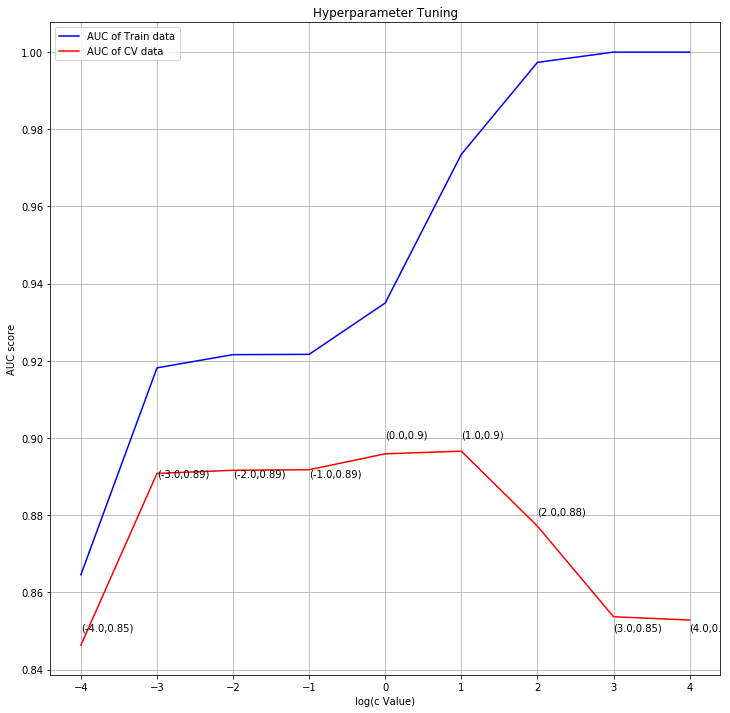

In [540]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose c=1, we get auc_score=0.90

In [541]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_RBF(best_c=1,train_vector=tfidf_w2v_train_fe_im,train_label=y_train_1,\
                               test_vector=tfidf_w2v_test_fe_im,test_label=y_test_1)

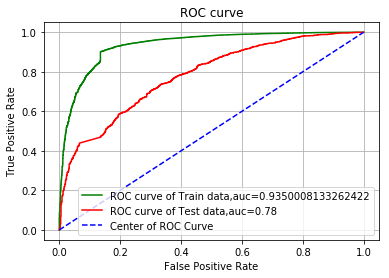

In [542]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

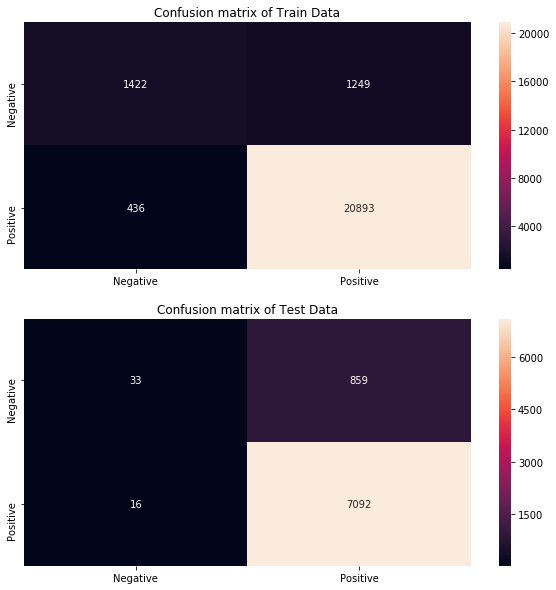

In [543]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train_1,test_proba=test_proba,test_label=y_test_1)

##### Observation:

* When we applying best hyperparameter (c=1) on model, we get auc score of future unseen data is 0.78

#### 9.2 Adding Review Text length as a feature with Review and Summary Text vector

In [544]:
# Lengh of the Words in Each Review document

a=[]
for i in preprocessed_text_data:
    a.append(len(i.split()))

In [545]:
# Adding Length as a new Feature in DataFrame

filter_data["Length"]=a

##### 9.2.1Column Standardization using Standardization Formula:

* $\ (Xi-mean)/std $

In [546]:
mean1=filter_data.Length.mean()
std1=filter_data.Length.std()

In [547]:
b=a
c=[]
for i in b:
    stand=(i-mean1)/std1
    c.append(abs(stand))

In [548]:
filter_data.Length=c

##### 9.2.2. Data Splitting

In [549]:
# we took the sample data size as 100k 

final_data=filter_data[:40000]
final_data.shape

(40000, 11)

In [550]:
X=final_data.Length
Y=final_data.Score

In [551]:
x_1,x_test_3,y_1,y_test_3=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train_3,x_cv_3,y_train_3,y_cv_3=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train_3.shape,y_train_3.shape)

print("cv data size")
print(x_cv_3.shape,y_cv_3.shape)
print("Test data size")
print(x_test_3.shape,y_test_3.shape)

 Train data Size
(24000,) (24000,)
cv data size
(8000,) (8000,)
Test data size
(8000,) (8000,)


##### 9.2.3 Horizontally stacking

##### Feature Engineering on TFIDF-W2V

In [553]:
# hstack takes list of list values. so we convert list to list of list

# For BOW
a_train=[]
for i in x_train_3.values:
    b=[]
    b.append(i)
    a_train.append(b)
    
a_cv=[]
for i in x_cv_3.values:
    b=[]
    b.append(i)
    a_cv.append(b)
    
a_test=[]
for i in x_test_3.values:
    b=[]
    b.append(i)
    a_test.append(b)

In [554]:
# For Training Data
tfidf_w2v_train_fe_im1=np.hstack((tfidf_w2v_train_fe_im,a_train))


# For cv Data

tfidf_w2v_cv_fe_im1=np.hstack((tfidf_w2v_cv_fe_im,a_cv))


# For test Data

tfidf_w2v_test_fe_im1=np.hstack((tfidf_w2v_test_fe_im,a_test))

In [555]:
tfidf_w2v_train_fe_im1.shape

(24000, 101)

##### 9.2.4 Feature engineering on RBF Kernel SVM

In [557]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [558]:
log_c=[]
for i in c:
    log_c.append(math.log10(i))
log_c

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

In [559]:
# Hyperparameter tuning

auc_train,auc_cv=RBF_kernal(c=c,train_vector=tfidf_w2v_train_fe_im1,train_label=y_train_1, \
                                             cv_vector=tfidf_w2v_cv_fe_im1,cv_label=y_cv_1)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [27:12<00:00, 252.41s/it]


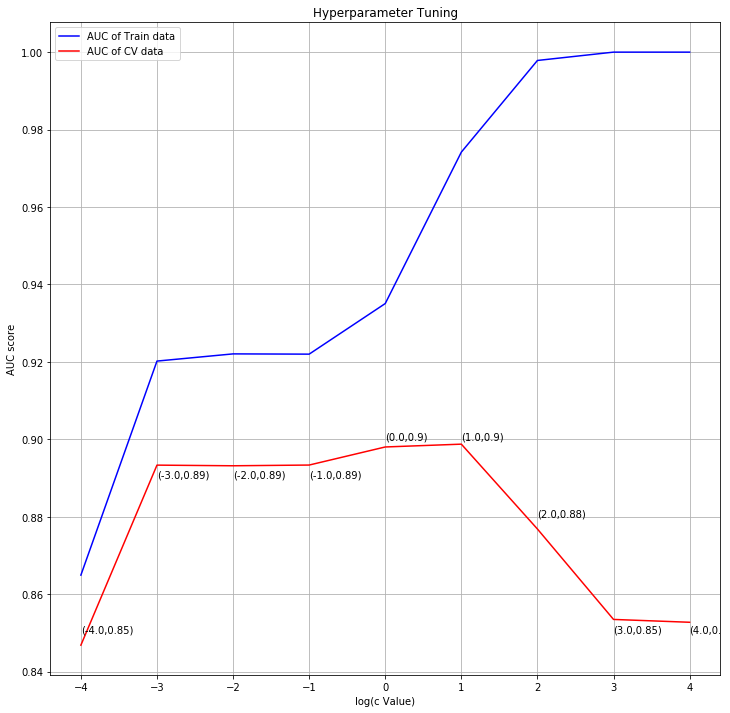

In [560]:
# auc_score plotting

auc_score(c_value=log_c,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose c=1, we get auc_score=0.90

In [562]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_RBF(best_c=1,train_vector=tfidf_w2v_train_fe_im1,train_label=y_train_1,\
                               test_vector=tfidf_w2v_test_fe_im1,test_label=y_test_1)

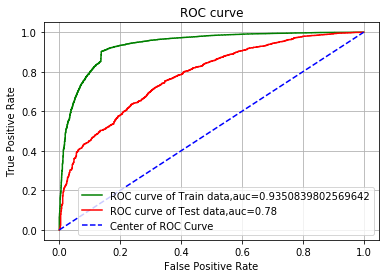

In [563]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

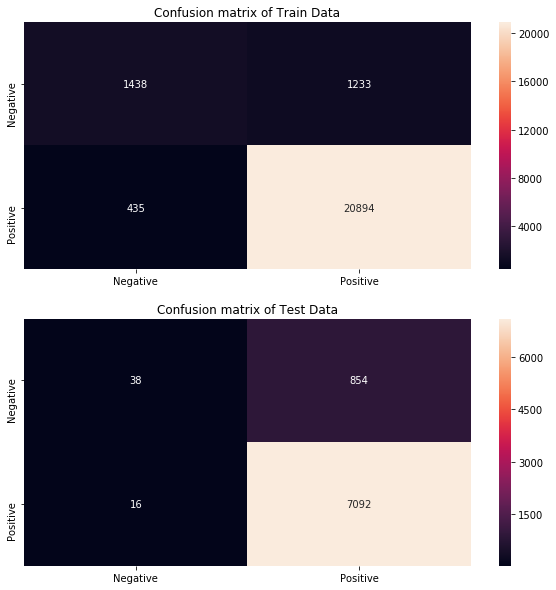

In [564]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train_1,test_proba=test_proba,test_label=y_test_1)

##### Observation:

* When we applying best hyperparameter (c=1) on model, we get auc score of future unseen data is 0.78

#### 9.3 Model Observations After Feature Engineering

In [565]:
z = PrettyTable()
m = PrettyTable()
print ("After Applying Feature Engineering on Model")
print(' ')
print("Feature Engineering( Review Text + Summary)")
print(' ')
z.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
z.add_row(["TFIDF W2V","RBF  Kernal SVM",1,0.78])
print(z)
print(' ')
print("Feature Engineering (Review Text + Summary + Length)")
print(' ')
m.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
m.add_row(["TFIDF W2V","RBF  Kernal SVM",1,0.78])
print(m)

After Applying Feature Engineering on Model
 
Feature Engineering( Review Text + Summary)
 
+------------+-----------------+----------------+------+
| Vectorizer |      Model      | Hyperparameter | AUC  |
+------------+-----------------+----------------+------+
| TFIDF W2V  | RBF  Kernal SVM |       1        | 0.78 |
+------------+-----------------+----------------+------+
 
Feature Engineering (Review Text + Summary + Length)
 
+------------+-----------------+----------------+------+
| Vectorizer |      Model      | Hyperparameter | AUC  |
+------------+-----------------+----------------+------+
| TFIDF W2V  | RBF  Kernal SVM |       1        | 0.78 |
+------------+-----------------+----------------+------+


* After applying Feature Engineering on the RBF Kernel Model (TFIDF W2V), The Summary Text is used to improve the model performance. But the length does not make any impact on the model. So we just ignore the length feature. Therefore we will use Summary Text as a feature for further model performance improvement.

### 10. Conclusion

In [569]:
print ("1. Before Applying Feature Engineering on Model(Review Text)")
print(' ')
print(x)
print(y)
print(' ')
print ("2. After Applying Feature Engineering on Model")
print(' ')
print("Feature Engineering( Review Text + Summary)")
print(' ')
print(z)
print("Feature Engineering (Review Text + Summary + Length)")
print(' ')
print(m)

1. Before Applying Feature Engineering on Model(Review Text)
 
+------------+----------------+-------------------+----------------+------+
| Vectorizer | Regularization |       Model       | Hyperparameter | AUC  |
+------------+----------------+-------------------+----------------+------+
|    BOW     |       l2       | Linear Kernal SVM |       1        | 0.91 |
|   TFIDF    |       l2       | Linear Kernal SVM |       1        | 0.93 |
|  Avg W2V   |       l2       | Linear Kernal SVM |      0.01      | 0.9  |
| TFIDF W2V  |       l2       | Linear Kernal SVM |       1        | 0.87 |
|    BOW     |       l1       | Linear Kernal SVM |     0.001      | 0.78 |
|   TFIDF    |       l1       | Linear Kernal SVM |     0.0001     | 0.83 |
|  Avg W2V   |       l1       | Linear Kernal SVM |     0.001      | 0.89 |
| TFIDF W2V  |       l1       | Linear Kernal SVM |     0.001      | 0.86 |
+------------+----------------+-------------------+----------------+------+
+------------+-----------

##### Data Cleaning ,Preprocessing and splitting:

* In the Data Cleaning process, we clean the duplicate datapoints and unconditioning data points. After the data cleaning process we get 364171 data points and sort based on timestamp.
* Then select the Review Text Feature as a important feature, then do data preprocessing on all the data points.
* Then select top 100k sample data points for further process of Linear Kernel SVM. and then split the 100k data points using simple cross validation technique. Train= 60000, CV=20000, Test=20000.
* Then select top 40k sample data points for further process of RBF Kernel SVM. and then split the 40k data points using simple cross validation technique. Train= 24000, CV=8000, Test=8000.


##### Featurization:

* Then apply the data points on BOW,TFIDF,Avg W2V and TFIDF W2V for converting text to vector.

#####  Linear SVM  Model: 

* Then apply these featurization vector on Linear SVM model using SGD Classifier. In this model we perform L1 and L2 regularization.
* Linear Kernel SVM model using L2 regularization gives better result compare to L1 regularization.
* TFIDF vectorizer gives better result compared to other vectorizers in L2 Regularization.
* Avg W2V vectorizer gives better result compared to other vectorizers in L1 Regularization.

#####  RBF Kernel SVM  Model: 

* Then apply these featurization vector on RBF Kernel SVM model.
* TFIDF vectorizer gives better result compared to other vectorizers.
* TFIDF W2V gives Random model we can improve that model further by using Feature Engineering and also improve by model by choosing more number datapoints.

##### Feature Importance (Pertubation Test):

* We took the TFIDF and BOW vectors of Linear Kernel SVM for the feature importance, because In RBF Kernal SVM is hard to find the Feature Importance.
* The multicollinearity of the feature is find out by using pertubation test. Multicollinear feature affect the model, Because small change in the train data set produce large difference. So model become poor. To ignore this problem we use the pertubation test to find out the multicollinearity.
* After pertubation test the Multicollinearity features are removed from the weight vector, then the weight vector consider for the Feature Importance.
* Then took the top 20 important features both positive and negative class.

##### Feature Engineering:

* we took TFIDF- W2V of RBF Kernel SVM for feature engineering, because its result is poor compared to other Model Vectors.
* We will apply feature engineering for improve the RBF Kernel SVM (TFIDF W2V) Model performance. Therfore we will consider Summary and Review Text Length as a feature.
* After applying Feature Engineering on the RBF Kernel Model (TFIDF W2V), The Summary Text is used to improve the model performance. But the length does not make any impact on the model. So we just ignore the length feature. Therefore we will use Summary Text as a feature for further model performance improvement.